# Explore & Prepare Iowa Liquor Sales Data

## Executive Summary

**What is this notebook for?**

- To explore the data properties and data quality of the transactional data obtained from BigQuery public dataset 
- To correct crucial data quality issues (only "low-hanging fruits") 
- To summarise transactional data into an appropriate format to be used for further EDA and ML pipeline for the demand forecasting model

**What have we learned from this notebook?**

1. Known data quality issues & how to fix them 
    1. Missing values
        - city: extract city from store_name
        - county: infer from the imputed values for missing city
        - category_name: impute based on category_name of the same items from other records
        - vendor_name: impute based on vendor_name of the same items from other records
        - (Completed) sale_dollars: remove records with missing labels (i.e. sale_dollars = 0)
    2. Inconsistent values
        - (Completed) county: convert all values to all CAPS
        - (Completed) city: correct some spelling inconsistencies with a dictionary based on Wikipedia page
        - (Completed) vendor_name: standardise between different versions of vendor names
        - (Completed) item_number and item_description: favour the longer description 
        - (Completed) For bottles_sold = 0, calculate the bottles_sold = sale_dollars / state_bottle_cost.  
2. Distribution & Outliers
    - All numerical features are heavily skewed. 
    - (Completed) Remove outliers for sale_dollars:remove records with sale_dollars exceeding $100,000.
3. Redundant features that can be removed
    - volume_sold_gallons: since it contains the same information as volume_sold_liters, just in another unit of measurement

**What are the next steps after this notebook?**
1. To use the summarised_sale.pkl file for EDA, feature selection and feature engineering. 
    - sale_dollars, bottles_sold, volume_sold_liters: Create new features with time lags (1 week, 3 days, 1 month and so on) to avoid looking-ahead bias 
    - date: Create new features for year, season, month, day of week, weekday and weekend, holidays 
    - (Optional) Enrich existing dataset with population of city or county
2. To correct outstanding data quality issues (after assessing the feature's predictive power) 

## Data Sources

all_sales.pkl: Retrieved from [Google BigQuery](https://console.cloud.google.com/marketplace/product/iowa-department-of-commerce/iowa-liquor-sales?project=australiarain&folder=&organizationId=) public dataset and contained sales data from 2018 onwards in pickle format

## Revision History

- 04-15-2021: Started the project
- 04-17-2021: Summarised transactional data

## Required Python Libraries

In [1]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# EDA

# Chi-square test and t-test for EDA
from scipy.stats import chi2_contingency
from scipy import stats

# Logistic correlation for EDA
import statsmodels.api as sm

# Data Visualisation for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set up matplotlib so it uses Jupyter's graphical backend when plotting the charts
%matplotlib inline 

# Adjust display options for pandas dataframes
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 60)
pd.set_option('float_format','{:.2f}'.format)

## File Locations

In [2]:
raw_data = Path.cwd().parent / "data" / "raw" / "all_sales.pkl"

# Summarise transactional data into training dataset for demand forecasting
summarised_data = Path.cwd().parent / "data" / "processed" / "summary_sales.parquet"

# Master file for common dimensions
item_data = Path.cwd().parent / "data" / "interim" / "item_list.parquet"

## Load the data & basic exploration

In [3]:
liquor_df = pd.read_pickle(raw_data)
liquor_df.tail(10)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
7966717,INV-35473200033,2021-03-31,4673,Sonny's Super Market / West Point,327 5th St,West Point,52656,POINT (-91.452491 40.717867),56,LEE,1012100,Canadian Whiskies,380,Phillips Beverage,14474,Revel Stoke Roasted Pecan,12,750,8.34,12.51,2,25.02,1.50,0.39
7966718,INV-35469200013,2021-03-31,3990,Cork and Bottle / Oskaloosa,309 A Ave West,Oskaloosa,52577,POINT (-92.648153 41.296228),62,MAHASKA,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28866,Tanqueray Gin,12,750,13.50,20.25,2,40.50,1.50,0.39
7966719,INV-35464100003,2021-03-31,5669,Guddi Mart / Waterloo,306 Byron Ave,Waterloo,50702,POINT (-92.353141 42.480288),7,BLACK HAWK,1022200,100% Agave Tequila,035,BACARDI USA INC,88294,Patron Silver,12,375,14.50,21.75,12,261.00,4.50,1.18
7966720,INV-35446900009,2021-03-31,4149,Fareway Stores #015 / Denison,609 Arrowhead Dr,Denison,51442,POINT (-95.371847 42.024517),24,CRAWFORD,1031200,American Flavored Vodka,521,JEM Beverage Company,39839,Western Son Prickly Pear,12,750,9.01,13.52,3,40.56,2.25,0.59
7966721,INV-35451300013,2021-03-31,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1031200,American Flavored Vodka,380,Phillips Beverage,41604,UV Grape,12,750,7.00,10.50,12,126.00,9.00,2.37
7966722,INV-35455700012,2021-03-31,2556,Hy-Vee Wine and Spirits / Estherville,1033 Central Avenue,Estherville,51334,POINT (-94.829962 43.402096),32,EMMET,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19067,Jim Beam,12,1000,12.59,18.89,12,226.68,12.00,3.17
7966723,INV-35481200057,2021-03-31,2521,Hy-Vee Food and Drug / Grand / WDM,1990 Grand Avenue,West Des Moines,50265,POINT (-93.73162 41.571127),77,POLK,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19476,Makers Mark,12,750,17.50,26.25,12,315.00,9.00,2.37
7966724,INV-35466400035,2021-03-31,3622,Wal-Mart 1415 / Spirit Lake,2600 Hwy 71,Spirit Lake,51360,POINT (-95.126535 43.416452),30,DICKINSON,1011400,Tennessee Whiskies,346,OLE SMOKY DISTILLERY LLC,86987,Ole Smoky Salty Watermelon Tennessee Whiskey,6,750,10.00,15.00,6,90.00,4.50,1.18
7966725,INV-35452200009,2021-03-31,4083,Fareway Stores #909 / Ankeny,109 SE Oralabor Rd,Ankeny,50021,POINT (-93.59949600000002 41.702811),77,POLK,1011400,Tennessee Whiskies,085,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750,15.57,23.36,12,280.32,9.00,2.37
7966726,INV-35450600113,2021-03-31,2500,Hy-Vee Food Store #1 / Ames,3800 W Lincoln Way,Ames,50010,None,85,STORY,1082000,Imported Cordials & Liqueurs,035,BACARDI USA INC,66836,St Germain,6,750,20.00,30.00,4,120.00,3.00,0.79


In [4]:
liquor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7966727 entries, 0 to 7966726
Data columns (total 24 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   invoice_and_item_number  object        
 1   date                     datetime64[ns]
 2   store_number             object        
 3   store_name               object        
 4   address                  object        
 5   city                     object        
 6   zip_code                 object        
 7   store_location           object        
 8   county_number            object        
 9   county                   object        
 10  category                 object        
 11  category_name            object        
 12  vendor_number            object        
 13  vendor_name              object        
 14  item_number              object        
 15  item_description         object        
 16  pack                     int64         
 17  bottle_volume_ml         in

In [5]:
liquor_df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00
mean,12.32,871.61,10.53,15.79,11.20,147.49,9.29,2.45
std,8.06,522.32,9.36,14.04,31.51,509.32,37.55,9.92
min,1.00,20.00,0.33,0.50,0.00,0.00,0.02,0.00
25%,6.00,750.00,5.54,8.31,3.00,35.28,1.50,0.40
50%,12.00,750.00,8.43,12.65,6.00,78.00,4.80,1.26
75%,12.00,1000.00,13.00,19.50,12.00,148.68,10.50,2.77
max,60.00,6000.00,1871.20,2806.80,13200.00,279557.28,13200.00,3487.07


In [6]:
# Check for missing values
liquor_df.isnull().sum()

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                      6657
city                         6657
zip_code                     6657
store_location             739268
county_number                6659
county                       6657
category                     5621
category_name                5621
vendor_number                   6
vendor_name                     6
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               0
state_bottle_retail             0
bottles_sold                    0
sale_dollars                    0
volume_sold_liters              0
volume_sold_gallons             0
dtype: int64

Information about what each column in the dataset mean can be found [here](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy). Below are a few key points to take note. 
- pack: The number of bottles in a case for the liquor ordered
- bottle_volume_ml: Volume of each liquor bottle ordered in milliliters.
- state_bottle_cost: The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
- state_bottle_retail: The amount the store paid for each bottle of liquor ordered
- sale_bottles: The number of bottles of liquor ordered by the store
- sale_dollars: Total cost of liquor order (number of bottles multiplied by the state bottle retail)
- sale_liters: Total volume of liquor ordered in liters. (i.e. (Bottle Volume (ml) x Bottles Sold)/1,000)
- sale_gallons: Total volume of liquor ordered in gallons. (i.e. (Bottle Volume (ml) x Bottles Sold)/3785.411784)

The key takeaway here is sale_liters and sale_gallons are the same feature (i.e. Bottle Volume x Bottles Sold), but represented in different units of measurement. I decided to drop sale_gallons from the analysis because sale_liters is sufficient to assess predictive power of Bottle Volume x Bottles Sold.

## Exploring Transactional Data

### Categorical features

In [7]:
# Check the number of unique values (i.e. cardinality) for each categorical feature
cat_feature = ['date', 'city', 'county', 'category_name', 'vendor_name', 'item_description']
liquor_df[cat_feature].nunique()

date                 847
city                 446
county               132
category_name         59
vendor_name          289
item_description    5940
dtype: int64

A quick background check showed Iowa has 99 counties. Therefore, the 'county' feature might contain inconsistent values, which need to be checked and dealt with later. 

Additionally, such a high cardinality across all categorical features make it slightly more challenging to visualise the potential correlation between liquor demand and each categorical feature with bar plot at a later stage. 

#### date

In [8]:
# Create new features for year, month and day of the week
liquor_df['year'] = pd.DatetimeIndex(liquor_df['date']).year
liquor_df['month'] = pd.DatetimeIndex(liquor_df['date']).month
liquor_df['day_of_week'] = pd.DatetimeIndex(liquor_df['date']).dayofweek
liquor_df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
0,INV-09550400072,2018-01-02,2549,Hy-Vee Food Store / Indianola,910 N Jefferson,Indianola,50125,None,91,WARREN,1011300,Single Barrel Bourbon Whiskies,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,20.17,30.26,6,181.56,4.50,1.19,2018,1,1
1,INV-09567800094,2018-01-02,2505,Hy-Vee Wine and Spirits / Boone,1111 8TH ST,Boone,50036,POINT (-93.876159 42.06479800000001),8,BOONE,1062500,Flavored Rum,260,DIAGEO AMERICAS,43352,Captain Morgan Pineapple,12,750,8.26,12.39,2,24.78,1.50,0.40,2018,1,1
2,INV-09561800137,2018-01-02,2564,Hy-Vee Food Store #4 / Waterloo,4000 University,Waterloo,50701,POINT (-92.403843 42.505197),7,BLACK HAWK,1031100,American Vodkas,259,Heaven Hill Brands,35418,Burnett's Vodka 80 Prf,6,1750,9.48,14.22,6,85.32,10.50,2.77,2018,1,1
3,INV-09554500039,2018-01-02,4844,Iowa City Fast Break,"2580, Naples Ave",Iowa City,52240,POINT (-91.571064 41.632792),52,JOHNSON,1031100,American Vodkas,260,DIAGEO AMERICAS,37993,Smirnoff 80prf,48,200,2.54,3.81,48,182.88,9.60,2.54,2018,1,1
4,INV-09558700018,2018-01-02,3691,Target Store T-1791 / Urbandale,11148 Plum Dr,Urbandale,50322,POINT (-93.769776 41.646972),77,POLK,1062500,Flavored Rum,260,DIAGEO AMERICAS,72913,Captain Morgan Loconut,6,750,9.06,13.59,6,81.00,4.50,1.19,2018,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966722,INV-35455700012,2021-03-31,2556,Hy-Vee Wine and Spirits / Estherville,1033 Central Avenue,Estherville,51334,POINT (-94.829962 43.402096),32,EMMET,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19067,Jim Beam,12,1000,12.59,18.89,12,226.68,12.00,3.17,2021,3,2
7966723,INV-35481200057,2021-03-31,2521,Hy-Vee Food and Drug / Grand / WDM,1990 Grand Avenue,West Des Moines,50265,POINT (-93.73162 41.571127),77,POLK,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19476,Makers Mark,12,750,17.50,26.25,12,315.00,9.00,2.37,2021,3,2
7966724,INV-35466400035,2021-03-31,3622,Wal-Mart 1415 / Spirit Lake,2600 Hwy 71,Spirit Lake,51360,POINT (-95.126535 43.416452),30,DICKINSON,1011400,Tennessee Whiskies,346,OLE SMOKY DISTILLERY LLC,86987,Ole Smoky Salty Watermelon Tennessee Whiskey,6,750,10.00,15.00,6,90.00,4.50,1.18,2021,3,2
7966725,INV-35452200009,2021-03-31,4083,Fareway Stores #909 / Ankeny,109 SE Oralabor Rd,Ankeny,50021,POINT (-93.59949600000002 41.702811),77,POLK,1011400,Tennessee Whiskies,085,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750,15.57,23.36,12,280.32,9.00,2.37,2021,3,2


The date feature has very high cardinality, which would create problems for the typical one-hot encoding process and hinder the ability for the model to generalise to predict with unseen data. Therefore, I will replace the date feature with either year, month or day_of_week, depending on the predictive power of each date-related feature. 

Note: For the feature day_of_week, it is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.

#### city

In [9]:
# Review records with missing values
null_city = liquor_df[liquor_df['city'].isnull()]
null_city

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
125,INV-09571700007,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1031100,American Vodkas,297,Laird & Company,35918,Five O'clock Vodka,6,1750,7.20,10.80,12,129.60,21.00,5.55,2018,1,1
2724,INV-09571700010,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64864,Fireball Cinnamon Whisky,24,375,5.33,8.00,10,80.00,3.75,0.99,2018,1,1
3558,INV-09571700005,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1011100,Blended Whiskies,260,DIAGEO AMERICAS,25604,Seagrams 7 Crown Bl Whiskey,24,375,3.50,5.25,6,31.50,2.25,0.59,2018,1,1
3891,INV-09571700011,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1082000,Imported Cordials & Liqueurs,192,"Mast-Jagermeister US, Inc",65254,Jagermeister Liqueur,24,375,6.52,9.78,6,58.68,2.25,0.59,2018,1,1
4010,INV-09571700008,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1031100,American Vodkas,300,McCormick Distilling Co.,36901,McCormick Vodka Mini,6,500,4.70,7.05,4,28.20,2.00,0.53,2018,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7779838,INV-34798100005,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1032100,Imported Vodkas,115,CONSTELLATION BRANDS INC,34820,Svedka 80prf,12,750,8.25,12.38,12,148.56,9.00,2.37,2021,3,4
7782076,INV-34798100007,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1081400,American Schnapps,055,SAZERAC NORTH AMERICA,81124,99 Peppermint Mini,10,50,5.16,7.74,10,77.40,0.50,0.13,2021,3,4
7782932,INV-34798100004,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1031100,American Vodkas,301,FIFTH GENERATION INC,38174,Titos Handmade Vodka,12,375,5.42,8.13,12,97.56,4.50,1.18,2021,3,4
7783118,INV-34798100009,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1062200,White Rum,035,BACARDI USA INC,43126,Bacardi Superior,12,750,8.26,12.39,4,49.56,3.00,0.79,2021,3,4


Since the store_name includes city name (e.g. Springville, Paullina), I will extract the city name from store_name to impute missing values. 

In [10]:
# Define a function to sort unique values of categorical feature to check for data validity and consistency
def sort_unique_values(feature):
    unique_values = feature.unique()
    not_null_values = [x for x in unique_values if x != None]
    print("There are ", len(not_null_values), " values that are not null.")
    return sorted(not_null_values)

In [11]:
sort_unique_values(liquor_df['city'])

There are  446  values that are not null.


['Ackley',
 'Adair',
 'Adel',
 'Afton',
 'Akron',
 'Albert City',
 'Albia',
 'Albion',
 'Alburnett',
 'Alden',
 'Algona',
 'Allerton',
 'Allison',
 'Alta',
 'Alton',
 'Altoona',
 'Amana',
 'Ames',
 'Anamosa',
 'Anita',
 'Ankeny',
 'Anthon',
 'Aplington',
 'Arlington',
 'Armstrong',
 "Arnold's Park",
 'Arnolds Park',
 'Atkins',
 'Atlantic',
 'Audubon',
 'Aurelia',
 'Avoca',
 'Baldwin',
 'Bancroft',
 'Baxter',
 'Bedford',
 'Belle Plaine',
 'Bellevue',
 'Belmond',
 'Bettendorf',
 'Bevington',
 'Blairstown',
 'Bloomfield',
 'Blue Grass',
 'Bondurant',
 'Boone',
 'Britt',
 'Brooklyn',
 'Buffalo',
 'Buffalo Center',
 'Burlington',
 'Bussey',
 'Calmar',
 'Camanche',
 'Cambridge',
 'Carlisle',
 'Carroll',
 'Carter Lake',
 'Cascade',
 'Casey',
 'Cedar Falls',
 'Cedar Rapids',
 'Center Point',
 'Centerville',
 'Central City',
 'Chariton',
 'Charles City',
 'Cherokee',
 'Clarence',
 'Clarinda',
 'Clarion',
 'Clarksville',
 'Clear Lake',
 'ClearLake',
 'Clermont',
 'Clinton',
 'Clive',
 'Coggon',


In [12]:
# Correct inconsistent name of cities
liquor_df['city'] = liquor_df['city'].replace({"Arnold's Park": 'Arnolds Park'
                                               , 'ClearLake': 'Clear Lake'
                                               , 'MUSCATINE': 'Muscatine'
                                               , 'SAGEVILLE': 'Sageville'})

#### county

In [13]:
# Review records with missing values
null_county = liquor_df[liquor_df['county'].isnull()]
null_county

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
125,INV-09571700007,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1031100,American Vodkas,297,Laird & Company,35918,Five O'clock Vodka,6,1750,7.20,10.80,12,129.60,21.00,5.55,2018,1,1
2724,INV-09571700010,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64864,Fireball Cinnamon Whisky,24,375,5.33,8.00,10,80.00,3.75,0.99,2018,1,1
3558,INV-09571700005,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1011100,Blended Whiskies,260,DIAGEO AMERICAS,25604,Seagrams 7 Crown Bl Whiskey,24,375,3.50,5.25,6,31.50,2.25,0.59,2018,1,1
3891,INV-09571700011,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1082000,Imported Cordials & Liqueurs,192,"Mast-Jagermeister US, Inc",65254,Jagermeister Liqueur,24,375,6.52,9.78,6,58.68,2.25,0.59,2018,1,1
4010,INV-09571700008,2018-01-02,4777,Casey's General Store #1365 / Paullina,None,None,None,None,None,None,1031100,American Vodkas,300,McCormick Distilling Co.,36901,McCormick Vodka Mini,6,500,4.70,7.05,4,28.20,2.00,0.53,2018,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7779838,INV-34798100005,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1032100,Imported Vodkas,115,CONSTELLATION BRANDS INC,34820,Svedka 80prf,12,750,8.25,12.38,12,148.56,9.00,2.37,2021,3,4
7782076,INV-34798100007,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1081400,American Schnapps,055,SAZERAC NORTH AMERICA,81124,99 Peppermint Mini,10,50,5.16,7.74,10,77.40,0.50,0.13,2021,3,4
7782932,INV-34798100004,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1031100,American Vodkas,301,FIFTH GENERATION INC,38174,Titos Handmade Vodka,12,375,5.42,8.13,12,97.56,4.50,1.18,2021,3,4
7783118,INV-34798100009,2021-03-05,4934,Casey's General Store #2811 / Springville,None,None,None,None,None,None,1062200,White Rum,035,BACARDI USA INC,43126,Bacardi Superior,12,750,8.26,12.39,4,49.56,3.00,0.79,2021,3,4


Since the store_name includes city name (e.g. Springville, Paullina), I will extract the city name from store_name, then look up the relevant county to impute missing values. 

In [14]:
sort_unique_values(liquor_df['county'])

There are  132  values that are not null.


['ADAIR',
 'ADAMS',
 'ALLAMAKEE',
 'APPANOOSE',
 'AUDUBON',
 'Adair',
 'BENTON',
 'BLACK HAWK',
 'BOONE',
 'BREMER',
 'BUCHANAN',
 'BUENA VIST',
 'BUTLER',
 'Black Hawk',
 'Boone',
 'Buchanan',
 'Butler',
 'CALHOUN',
 'CARROLL',
 'CASS',
 'CEDAR',
 'CERRO GORD',
 'CHEROKEE',
 'CHICKASAW',
 'CLARKE',
 'CLAY',
 'CLAYTON',
 'CLINTON',
 'CRAWFORD',
 'Cerro Gord',
 'Clayton',
 'DALLAS',
 'DAVIS',
 'DECATUR',
 'DELAWARE',
 'DES MOINES',
 'DICKINSON',
 'DUBUQUE',
 'Dallas',
 'Delaware',
 'Des Moines',
 'Dickinson',
 'EL PASO',
 'EMMET',
 'FAYETTE',
 'FLOYD',
 'FRANKLIN',
 'FREMONT',
 'Fayette',
 'GREENE',
 'GRUNDY',
 'GUTHRIE',
 'HAMILTON',
 'HANCOCK',
 'HARDIN',
 'HARRISON',
 'HENRY',
 'HOWARD',
 'HUMBOLDT',
 'Hancock',
 'Hardin',
 'Harrison',
 'Henry',
 'IDA',
 'IOWA',
 'Iowa',
 'JACKSON',
 'JASPER',
 'JEFFERSON',
 'JOHNSON',
 'JONES',
 'Jackson',
 'Jasper',
 'KEOKUK',
 'KOSSUTH',
 'Kossuth',
 'LEE',
 'LINN',
 'LOUISA',
 'LUCAS',
 'LYON',
 'Linn',
 'MADISON',
 'MAHASKA',
 'MARION',
 'MARSHA

Many county values are inconsistent because majority are written in all capital letters while other capitalises the first letter. I will correct the inconsistencies below. 

In [15]:
# Convert values to ALL CAPS to correct data inconsistency
liquor_df['county'] = liquor_df['county'].str.upper()

After validating against the list of counties in Iowa from [Wikipedia](https://en.wikipedia.org/wiki/List_of_counties_in_Iowa), all values are now consistent and accurate. 

On a side note, population in each county is vastly different. Population could potentially be useful in predicting demand because a larger population means more consumers. 

#### category_name

In [16]:
# Review records with missing values
null_category_name = liquor_df[liquor_df['category_name'].isnull()]
null_category_name

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
345,INV-09560100139,2018-01-02,2552,Hy-Vee Food Store #3 / Cedar Rapids,20 Wilson Avenue West,Cedar Rapids,52404,POINT (-91.658577 41.955859),57,LINN,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,2,33.18,1.50,0.40,2018,1,1
1415,INV-09567800090,2018-01-02,2505,Hy-Vee Wine and Spirits / Boone,1111 8TH ST,Boone,50036,POINT (-93.876159 42.06479800000001),8,BOONE,None,None,259,Heaven Hill Brands,36122,Deep Eddy,12,750,9.00,13.50,3,40.50,2.25,0.59,2018,1,1
5615,INV-09567900054,2018-01-02,5471,World Liquor & Tobacco + Vapors,1030 8th St,Boone,50036,POINT (-93.876918 42.063831),8,BOONE,None,None,035,BACARDI USA INC,43086,Bacardi Coco,12,750,8.25,12.38,2,24.76,1.50,0.40,2018,1,1
5616,INV-09557700043,2018-01-02,4171,"Brothers Market, Inc. / Cascade",105 SE Nixon St,Cascade,52033,POINT (-90.993859 42.3036),31,DUBUQUE,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,3,49.77,2.25,0.59,2018,1,1
10741,INV-09592900005,2018-01-03,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,None,None,187,KOVAL DISTILLERY,985554,Koval Millet,6,750,26.00,39.00,6,234.00,4.50,1.19,2018,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750948,INV-27570500113,2020-05-29,2505,Hy-Vee Wine and Spirits / Boone,1111 8TH ST,Boone,50036,POINT (-93.876107 42.063831),8,BOONE,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,2,28.26,1.50,0.39,2020,5,4
5751907,INV-27590300028,2020-05-29,2678,Hy-Vee Fast & Fresh / Davenport,3200 E KIMBERLY RD.,Davenport,52807,POINT (-90.527278 41.553879),82,SCOTT,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,1,14.13,0.75,0.19,2020,5,4
5757957,INV-27597200086,2020-05-29,3818,Round Window Liquor,703 W Pleasant St,Knoxville,50138,POINT (-93.10564100000002 41.320746),63,MARION,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,2,28.26,1.50,0.39,2020,5,4
5762463,INV-27583300059,2020-05-29,2607,Hy-Vee Wine and Spirits / Shenandoah,520 So Fremont,Shenandoah,51601,POINT (-95.385111 40.761736),73,PAGE,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,4,56.52,3.00,0.79,2020,5,4


In [17]:
liquor_df[liquor_df['item_description'] == "Blue Chair Bay Banana Rum Cream"]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
345,INV-09560100139,2018-01-02,2552,Hy-Vee Food Store #3 / Cedar Rapids,20 Wilson Avenue West,Cedar Rapids,52404,POINT (-91.658577 41.955859),57,LINN,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,2,33.18,1.50,0.40,2018,1,1
5616,INV-09557700043,2018-01-02,4171,"Brothers Market, Inc. / Cascade",105 SE Nixon St,Cascade,52033,POINT (-90.993859 42.3036),31,DUBUQUE,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,3,49.77,2.25,0.59,2018,1,1
15655,INV-09578000009,2018-01-03,3783,Dyno's Wine and Spirits / Pocahontas,14 1/2 E Elm,Pocahontas,50574,POINT (-94.66731100000001 42.732607),76,POCAHONTAS,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,4,66.36,3.00,0.79,2018,1,2
41409,INV-09656800055,2018-01-08,3549,Quicker Liquor Store,1414 48th St,Fort Madison,52627,POINT (-91.373211 40.62422600000001),56,LEE,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,9.42,14.13,1,16.59,0.75,0.20,2018,1,0
66130,INV-09707100014,2018-01-10,9906,Johnson Brothers Wirtz,2515 Dean Avenue,Des Moines,50317,POINT (-93.570027 41.591304),77,POLK,None,None,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,11.06,16.59,1,199.08,0.75,0.19,2018,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7956106,INV-35447500049,2021-03-31,2595,Hy-Vee Wine and Spirits / Denison,"1620 4th Ave, South",Denison,51442,POINT (-95.348601 42.012395),24,CRAWFORD,1062500,Flavored Rum,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,10.49,15.74,1,14.13,0.75,0.19,2021,3,2
7958441,INV-35449600079,2021-03-31,2502,Hy-Vee Wine and Spirits / Ankeny,410 North Ankeny Blvd,Ankeny,50021,None,77,POLK,1062500,Flavored Rum,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,10.49,15.74,6,84.78,4.50,1.18,2021,3,2
7958681,INV-35460100053,2021-03-31,3629,Wal-Mart 1965 / Council Bluffs,3200 Manawa Dr,Council Bluffs,51503,None,78,POTTAWATTA,1062500,Flavored Rum,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,10.49,15.74,12,169.56,9.00,2.37,2021,3,2
7961166,INV-35462800043,2021-03-31,3670,Wal-Mart 2827 / Coralville,2801 Commerce Dr,Coralville,52241,POINT (-91.610774 41.695806),52,JOHNSON,1062500,Flavored Rum,305,Mhw LTD,80024,Blue Chair Bay Banana Rum Cream,12,750,10.49,15.74,12,169.56,9.00,2.37,2021,3,2


Since other records have both category_number and category_name populated for the same items, I will use the same category_name to impute missing values. 

In [18]:
sort_unique_values(liquor_df['category_name'])

There are  59  values that are not null.


['100% Agave Tequila',
 'Aged Dark Rum',
 'American Brandies',
 'American Cordials & Liqueur',
 'American Cordials & Liqueurs',
 'American Distilled Spirit Specialty',
 'American Distilled Spirits Specialty',
 'American Dry Gins',
 'American Flavored Vodka',
 'American Schnapps',
 'American Sloe Gins',
 'American Vodka',
 'American Vodkas',
 'Blended Whiskies',
 'Bottled in Bond Bourbon',
 'Canadian Whiskies',
 'Cocktails / RTD',
 'Cocktails /RTD',
 'Coffee Liqueurs',
 'Corn Whiskies',
 'Cream Liqueurs',
 'Delisted / Special Order Items',
 'Distilled Spirits Specialty',
 'Flavored Gin',
 'Flavored Rum',
 'Gold Rum',
 'Imported Brandies',
 'Imported Cordials & Liqueur',
 'Imported Cordials & Liqueurs',
 'Imported Distilled Spirit Specialty',
 'Imported Distilled Spirits Specialty',
 'Imported Dry Gins',
 'Imported Flavored Vodka',
 'Imported Gins',
 'Imported Schnapps',
 'Imported Vodka',
 'Imported Vodkas',
 'Imported Whiskies',
 'Iowa Distilleries',
 'Iowa Distillery Whiskies',
 'Iris

In [19]:
# Correct inconsistent name of liquor categories
liquor_df['category_name'] = liquor_df['category_name'].replace({'American Cordials & Liqueur': 'American Cordials & Liqueurs'
                                                                 , 'American Distilled Spirit Specialty': 'American Distilled Spirits Specialty'
                                                                 , 'American Vodka': 'American Vodkas'
                                                                 , 'Cocktails /RTD': 'Cocktails / RTD'
                                                                 , 'Imported Cordials & Liqueur': 'Imported Cordials & Liqueurs'
                                                                 , 'Imported Distilled Spirit Specialty': 'Imported Distilled Spirits Specialty'
                                                                 , 'Imported Vodka': 'Imported Vodkas'
                                                                 , 'Iowa Distilleries': 'Iowa Distillery Whiskies'
                                                                 , 'Temporary  & Specialty Packages': 'Temporary & Specialty Packages'
                                                                 , 'Temporary &  Specialty Packages': 'Temporary & Specialty Packages'})

#### vendor_name

In [20]:
# Review records with missing values
null_vendor_name = liquor_df[liquor_df['vendor_name'].isnull()]
null_vendor_name

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
961895,INV-12438800004,2018-06-04,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1012100,Canadian Whiskies,None,None,910621,Canadian Club Whisky Mini,12,50,13.25,8.91,12,106.92,0.60,0.16,2018,6,0
1377574,INV-13688900001,2018-08-07,4167,"Iowa Street Market, Inc.",1256 Iowa St,Dubuque,52001,POINT (-90.668138 42.504959),31,DUBUQUE,1081300,American Cordials & Liqueurs,None,None,973449,Dekuyper Blood Orange,12,1000,14.75,11.81,36,425.16,36.00,9.51,2018,8,1
4390974,INV-23231800001,2019-11-14,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1081300,American Cordials & Liqueurs,None,None,984151,99 Oranges,12,750,28.50,11.69,12,140.28,9.00,2.37,2019,11,3
7502390,INV-33740700003,2021-01-25,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1012400,Irish Whiskies,None,None,915574,Connemara 12 Year,6,750,14.66,56.25,6,337.50,4.50,1.18,2021,1,0
7503610,INV-33728600005,2021-01-25,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1022200,100% Agave Tequila,None,None,988100,Monte Alban Silver,12,750,12.98,15.56,12,186.72,9.00,2.37,2021,1,0
7866164,INV-35139200005,2021-03-18,5251,Northside Liquor,1303 North Federal,Mason City,50401,POINT (-93.201061 43.163663),17,CERRO GORD,1032100,Imported Vodkas,None,None,965108,Grey Goose VX,6,1000,31.34,80.00,18,1440.00,18.00,4.75,2021,3,3


In [21]:
liquor_df[liquor_df['item_description'] == "Grey Goose VX"]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
132744,INV-09963600058,2018-01-23,5326,Als Liquor,215 W. Milwaukee Ave,Storm Lake,50588,POINT (-95.202405 42.647492),11,BUENA VIST,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,4,198.00,3.00,0.79,2018,1,1
139924,INV-10001400125,2018-01-24,2621,Hy-Vee Food Store #3 / Sioux City,3301 Gordon Dr,Sioux City,51105,POINT (-96.364108 42.487752),97,WOODBURY,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,1,49.50,0.75,0.20,2018,1,2
141097,INV-09973900046,2018-01-24,2566,Hy-Vee Food Store / Knoxville,813 N Lincoln Ste 1,Knoxville,50138,None,63,MARION,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,4,198.00,3.00,0.79,2018,1,2
149241,INV-10017500001,2018-01-25,5307,Fareway Store # 167/Johnston,6005 Merle Hay Road,Johnston,50131,POINT (-93.697658 41.670127),77,POLK,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,4,198.00,3.00,0.79,2018,1,3
152168,INV-10010000059,2018-01-25,5251,Northside Liquor,"1303, North Federal",Mason City,50401,POINT (-93.201061 43.163663),17,CERRO GORD,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,8,396.00,6.00,1.59,2018,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318260,INV-16588500005,2018-12-27,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,2,99.00,1.50,0.39,2018,12,3
2332766,INV-16611500012,2018-12-28,4969,Lake Liquors Wine and Spirits,910 N 8th St W,Clear Lake,50428,POINT (-93.396651 43.142775),17,CERRO GORD,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,1,49.50,0.75,0.19,2018,12,4
2379892,INV-16759700021,2019-01-04,4877,World Liquor & Tobacco,1775 NW 86th St,Clive,50325,POINT (-93.736232 41.607853),77,POLK,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,1,49.50,0.75,0.19,2019,1,4
2535630,INV-17268600015,2019-01-31,4969,Lake Liquors Wine and Spirits,910 N 8th St W,Clear Lake,50428,POINT (-93.396651 43.142775),17,CERRO GORD,1032100,Imported Vodkas,035,BACARDI USA INC,65109,Grey Goose VX,4,750,33.00,49.50,1,49.50,0.75,0.19,2019,1,3


Since other records have vendor_name populated for the same items, I will use the same vendor_name to impute missing values. 

In [22]:
sort_unique_values(liquor_df['vendor_name'])

There are  289  values that are not null.


['3 BADGE CORPORATION',
 '3-Oaks Distillery, LLC',
 '45TH PARALLEL SPIRITS',
 'A HARDY USA LTD',
 'AHA TORO SPIRITS INC',
 'AHA TORO SPIRITS INC / Aha Yeto Tequila',
 'AIKO IMPORTERS INC',
 'AMERICAN SPIRITS EXCHANGE',
 'AMERICAN VINTAGE BEVERAGE',
 'ARTISAN GRAIN DISTILLERY',
 'Allegheny Distilling LLC',
 'Altamar Brands LLC',
 'American Heritage Distillers, LLC',
 'American Heritage Distillers, LLC / Century Farms Distillery',
 'B. T. O. Distillers LLC',
 'BACARDI USA INC',
 'BAD BEAR ENTERPRISES LLC',
 'BAD BEAR ENTERPRISES LLC / Legendary Rye',
 'BENDISTILLERY',
 'BLACK ROCK SPIRITS',
 'BLAUM BROTHERS DISTILLING CO',
 'BMC Imports',
 'BRECKENRIDGE DISTILLERY',
 'BROADBENT VENTURES LLC',
 'Best Case Wines LLC',
 'Black Sea Imports, Inc',
 'Bluff Creek Distillery',
 'Bom Dia Imports LLC',
 'Boot Hill Distillery LLC',
 'Brown Forman Corp.',
 'Bucktown Distilling Co., LLC / Artisan Grain Distillery',
 'CARRIAGE HOUSE IMPORTS',
 'CEDAR RIDGE VINEYARDS LL',
 'CH Distillery',
 'CH Distill

In [23]:
liquor_df[liquor_df['vendor_name'] == 'Traverse City Whiskey Co']

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
508441,INV-11116900007,2018-03-26,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994852,Traverse City Whiskey Co. Port Barrel Finished...,6,750,21.66,32.49,6,194.94,4.50,1.19,2018,3,0
1087668,INV-12825800001,2018-06-22,3698,Ingersoll Wine Merchants,1300 50th St,West Des Moines,50266,POINT (-93.771159 41.590871),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994850,Traverse City Whiskey Co. American Cherry Edition,6,750,19.33,29.00,6,174.00,4.50,1.19,2018,6,4
1089493,INV-12825800002,2018-06-22,3698,Ingersoll Wine Merchants,1300 50th St,West Des Moines,50266,POINT (-93.771159 41.590871),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994849,Traverse City Whiskey Co. XXX Straight Bourbon,6,750,19.33,29.00,6,174.00,4.50,1.19,2018,6,4
1092464,INV-12868500006,2018-06-25,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011600,Straight Rye Whiskies,428,Traverse City Whiskey Co,994851,Traverse City Whiskey Co. North Coast Rye,6,750,21.66,32.49,12,389.88,9.00,2.38,2018,6,0
1958337,INV-15496900003,2018-11-05,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994852,Traverse City Whiskey Co. Port Barrel Finished...,6,750,21.66,32.49,12,389.88,9.00,2.37,2018,11,0
2550204,INV-17320400010,2019-02-04,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994850,Traverse City Whiskey Co. American Cherry Edition,6,750,19.33,29.00,6,174.00,4.50,1.18,2019,2,0
2637940,INV-17621900014,2019-02-18,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994849,Traverse City Whiskey Co. XXX Straight Bourbon,6,750,19.33,29.00,6,174.00,4.50,1.18,2019,2,0
3195468,INV-19395500003,2019-05-16,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994853,Traverse City Whiskey Co. Barrel Proof Bourbon,6,750,40.50,60.75,6,364.50,4.50,1.18,2019,5,3
3198245,INV-19414800001,2019-05-17,3698,Ingersoll Wine Merchants,1300 50th St,West Des Moines,50266,POINT (-93.771159 41.590871),77,POLK,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994850,Traverse City Whiskey Co. American Cherry Edition,6,750,19.33,29.00,12,348.00,9.00,2.37,2019,5,4
3625810,INV-20697200002,2019-07-18,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1011200,Straight Bourbon Whiskies,428,Traverse City Whiskey Co,994849,Traverse City Whiskey Co. XXX Straight Bourbon,6,750,19.33,29.00,12,348.00,9.00,2.37,2019,7,3


In [24]:
liquor_df[liquor_df['vendor_name'] == 'Traverse City Whiskey Co / TCWC, LLC']

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
7150407,INV-32509100004,2020-12-08,5444,Marshall Beer Wine Spirits,11 N 3rd Ave,Marshalltown,50158,POINT (-92.908013 42.050021),64,MARSHALL,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994853,Traverse City Whiskey Co. Barrel Proof Bourbon,6,750,40.50,60.75,6,364.50,4.50,1.18,2020,12,1
7504949,INV-33730600018,2021-01-25,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994850,Traverse City Whiskey Co. American Cherry Edition,6,750,19.33,29.00,6,174.00,4.50,1.18,2021,1,0
7667333,INV-34365900005,2021-02-17,5941,Prime Mart - Cedar Falls,2728 Center St,Cedar Falls,50613,POINT (-92.455972 42.561054),7,BLACK HAWK,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994850,Traverse City Whiskey Co. American Cherry Edition,6,750,19.33,29.00,6,174.00,4.50,1.18,2021,2,2
7835312,INV-35006600018,2021-03-15,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994853,Traverse City Whiskey Co. Barrel Proof Bourbon,6,750,40.50,60.75,6,364.50,4.50,1.18,2021,3,0
7840858,INV-35006600019,2021-03-15,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994853,Traverse City Whiskey Co. Barrel Proof Bourbon,6,750,40.50,60.75,6,364.50,4.50,1.18,2021,3,0
7861864,INV-35080300006,2021-03-17,5941,Prime Mart - Cedar Falls,2728 Center St,Cedar Falls,50613,POINT (-92.455972 42.561054),7,BLACK HAWK,1011600,Straight Rye Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994851,Traverse City Whiskey Co. North Coast Rye,6,750,21.66,32.49,6,194.94,4.50,1.18,2021,3,2
7866239,INV-35122200001,2021-03-18,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1011600,Straight Rye Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994851,Traverse City Whiskey Co. North Coast Rye,6,750,21.66,32.49,6,194.94,4.50,1.18,2021,3,3
7929302,INV-35330200004,2021-03-26,5251,Northside Liquor,1303 North Federal,Mason City,50401,POINT (-93.201061 43.163663),17,CERRO GORD,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994849,Traverse City Whiskey Co. XXX Straight Bourbon,6,750,19.33,29.00,6,174.00,4.50,1.18,2021,3,4
7931716,INV-35330200002,2021-03-26,5251,Northside Liquor,1303 North Federal,Mason City,50401,POINT (-93.201061 43.163663),17,CERRO GORD,1011200,Straight Bourbon Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994850,Traverse City Whiskey Co. American Cherry Edition,6,750,19.33,29.00,6,174.00,4.50,1.18,2021,3,4
7934152,INV-35330200003,2021-03-26,5251,Northside Liquor,1303 North Federal,Mason City,50401,POINT (-93.201061 43.163663),17,CERRO GORD,1011600,Straight Rye Whiskies,428,"Traverse City Whiskey Co / TCWC, LLC",994851,Traverse City Whiskey Co. North Coast Rye,6,750,21.66,32.49,6,194.94,4.50,1.18,2021,3,4


After assessing transactional records related to inconsistent vendor_name values, I can conclude that the products are exactly the same even if vendor_name are captured differently (e.g. 'Traverse City Whiskey Co' VS 'Traverse City Whiskey Co / TCWC, LLC'). Therefore, I will proceed to standardise the vendor_name values according to the below rules of thumb (which aim to faciliate as much generalisation as possible). 
1. Between 2 versions of the same name, choose the more concise version. For example, choose 'Traverse City Whiskey Co' over 'Traverse City Whiskey Co / TCWC, LLC'
2. Between the old name and the new name of the same business, choose the newer name. For example, choose S&B Farms Distillery (new name) over S&B Farmstead Distllery (old name) 
3. Between the parent company and the child company, choose the parent company. For example, choose SAZERAC COMPANY  INC over SAZERAC NORTH AMERICA

In [25]:
# Correct inconsistent name of vendors
liquor_df['vendor_name'] = liquor_df['vendor_name'].replace({'AHA TORO SPIRITS INC / Aha Yeto Tequila': 'AHA TORO SPIRITS INC'
                                                             , 'American Heritage Distillers, LLC / Century Farms Distillery': 'American Heritage Distillers, LLC'
                                                             , 'BAD BEAR ENTERPRISES LLC / Legendary Rye': 'BAD BEAR ENTERPRISES LLC'
                                                             , 'CH Distillery / 773 LLC': 'CH Distillery'
                                                             , 'CVI Brands / California Vineyards Inc': 'CVI Brands'
                                                             , 'DUNKEL CORPORATION / Iowa Distilling': 'DUNKEL CORPORATION'
                                                             , 'Georgetown Trading Co. LLC / James Pepper Distilling Co.': 'Georgetown Trading Co. LLC'
                                                             , 'GoAmericaGo Beverages LLC / WhistlePig': 'GoAmericaGo Beverages LLC'
                                                             , 'MODERN SPIRIT LLC / Greenbar Distillery': 'MODERN SPIRIT LLC'
                                                             , 'Mast-Jagermeister US, Inc': 'Mast-Jaegermeister US, Inc'
                                                             , 'Paterno Imports LTD / Terlato Wines International': 'Paterno Imports LTD'
                                                             , 'Prestige Wine & Spirits Group / United States Distilled Products Co': 'Prestige Wine & Spirits Group'
                                                             , 'Purple Valley Imports / Glass Revolution Imports': 'Purple Valley Imports'
                                                             , 'S&B Farmstead Distillery': 'S&B Farms Distillery'
                                                             , 'SAZERAC NORTH AMERICA': 'SAZERAC COMPANY  INC'
                                                             , 'SUTTER HOME WINERY INC / Trinchero Family Estates': 'SUTTER HOME WINERY INC'
                                                             , 'Traverse City Whiskey Co / TCWC, LLC': 'Traverse City Whiskey Co'
                                                             , 'Vino.com dba Total Beverage Solution': 'VINO COM LLC'})

#### item_description

In [26]:
sort_unique_values(liquor_df['item_description'])

There are  5940  values that are not null.


['"Rumchata ""MiniChatas"" Creamer Cups"',
 '135° East Hyogo Japanese Dry Gin',
 '135� East Hyogo Japanese Dry Gin',
 '1792 12YR Old Bourbon',
 '1792 Bottle in Bond Bourbon',
 '1792 Bottled in Bond Bourbon',
 '1792 Bottled in Bond Bourbon Barrel',
 '1792 Full Proof',
 '1792 Full Proof Buy the Barrel',
 '1792 Single Barrel',
 '1792 Single Barrel Bourbon',
 '1792 Sweet Wheat Bourbon',
 '1800 Anejo',
 '1800 Anejo Tequila',
 '1800 Coconut',
 '1800 Cristalino',
 '1800 Peach',
 '1800 Peach Margarita',
 '1800 Reposado',
 '1800 Reposado Tequila',
 '1800 Silver',
 '1800 Silver 750ml w/1800 Coconut 200ml',
 '1800 Silver Mini',
 '1800 Silver Tequila',
 '1800 Silver Tequila 750ml w/ 1800 Coconut 200ml',
 '1800 Silver Tequila w/Replica Shot Glasses',
 '1800 Silver w/Flask',
 '1800 Ultimate Black Cherry Margarita',
 '1800 Ultimate Blood Orange Margarita',
 '1800 Ultimate Jalape�o',
 '1800 Ultimate Jalape�o Lime',
 '1800 Ultimate Jalape�o Lime Margarita',
 '1800 Ultimate Mango Margarita',
 '1800 Ulti

In [27]:
liquor_df[liquor_df['item_description'] == '99 Pineapple']

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
433,INV-09562600011,2018-01-02,2571,Hy-Vee Food Store #2 / Waterloo,2181 Logan Ave,Waterloo,50703,POINT (-92.337583 42.530476),7,BLACK HAWK,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.79,11.69,24,280.56,18.00,4.76,2018,1,1
2590,INV-09550800064,2018-01-02,2509,Hy-Vee / Drugtown #1 / Cedar Rapids,1520 6th St SW,Cedar Rapids,52404,POINT (-91.67706 41.962419),57,LINN,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.79,11.69,2,23.38,1.50,0.40,2018,1,1
8219,INV-09563800011,2018-01-02,3993,New Star Liquor / W 4th S / Waterloo,1625 West 4th St,Waterloo,50701,None,7,BLACK HAWK,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.79,11.69,2,23.38,1.50,0.40,2018,1,1
20089,INV-09577600008,2018-01-03,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77,POLK,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.79,11.69,24,280.56,18.00,4.76,2018,1,2
25786,INV-09615700051,2018-01-04,2521,Hy-Vee Food and Drug / Grand / WDM,1990 Grand Avenue,West Des Moines,50265,POINT (-93.73162 41.571127),77,POLK,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.79,11.69,6,70.14,4.50,1.19,2018,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7949459,INV-35440300041,2021-03-30,5645,Phillips 66 / Grinnell,1031 West St,Grinnell,50112,POINT (-92.727379 41.745903),79,POWESHIEK,1081400,American Schnapps,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.50,11.25,3,33.75,2.25,0.59,2021,3,1
7953355,INV-35411500026,2021-03-30,2663,Hy-Vee Food Store / Urbandale,8701 Douglas,Urbandale,50322,POINT (-93.739105 41.629364),77,POLK,1081400,American Schnapps,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.50,11.25,12,135.00,9.00,2.37,2021,3,1
7956266,INV-35451300021,2021-03-31,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1081400,American Schnapps,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.50,11.25,2,22.50,1.50,0.39,2021,3,2
7958832,INV-35460000008,2021-03-31,5314,Tobacco Hut & Liquor,3134 Manawa Center Dr. # 9,Council Bluffs,51501,POINT (-95.847514 41.228712),78,POTTAWATTA,1081400,American Schnapps,055,SAZERAC COMPANY INC,84201,99 Pineapple,12,750,7.50,11.25,1,11.25,0.75,0.19,2021,3,2


In [28]:
liquor_df[liquor_df['item_description'] == '99 Pineapple Mini']

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
4733,INV-09560100183,2018-01-02,2552,Hy-Vee Food Store #3 / Cedar Rapids,20 Wilson Avenue West,Cedar Rapids,52404,POINT (-91.658577 41.955859),57,LINN,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,600,6.00,9.00,10,90.00,6.00,1.59,2018,1,1
6922,INV-09568600114,2018-01-02,2661,Hy-Vee Food Store / Sheldon,1989 Park St,Sheldon,51201,POINT (-95.831721 43.186038),71,OBRIEN,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,600,6.00,9.00,4,36.00,2.40,0.63,2018,1,1
7002,INV-09569000110,2018-01-02,5423,Stammer Liquor Corp,615 2nd Ave,Sheldon,51201,POINT (-95.854899 43.184242),71,OBRIEN,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,600,6.00,9.00,3,27.00,1.80,0.48,2018,1,1
7813,INV-09556800234,2018-01-02,4167,"Iowa Street Market, Inc.",1256 Iowa St,Dubuque,52001,POINT (-90.668138 42.504959),31,DUBUQUE,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,600,6.00,9.00,2,18.00,1.20,0.32,2018,1,1
12698,INV-09576500179,2018-01-03,2616,Hy-Vee Food and Drug / Clinton,901 South 4th St,Clinton,52732,POINT (-90.193204 41.836268000000004),23,CLINTON,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,600,6.00,9.00,2,18.00,1.20,0.32,2018,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7960482,INV-35477100040,2021-03-31,3917,Smokin' Joe's #2 Tobacco and Liquor Outlet,1606 W Locust St,Davenport,52804,POINT (-90.599037 41.538254),82,SCOTT,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,50,5.16,7.74,1,7.74,0.05,0.01,2021,3,2
7960849,INV-35475400049,2021-03-31,2611,Hy-Vee Drugstore / Ottumwa,1140 North Jefferson St,Ottumwa,52501,POINT (-92.401538 41.026754000000004),90,WAPELLO,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,50,5.16,7.74,2,15.48,0.10,0.02,2021,3,2
7962428,INV-35460900023,2021-03-31,5849,Super Quick Stop - Council Bluffs,2800 Twin City Dr. Suite 10,Council Bluffs,51501,POINT (-95.889605 41.216413),78,POTTAWATTA,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,50,5.16,7.74,20,154.80,1.00,0.26,2021,3,2
7963261,INV-35458300182,2021-03-31,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84197,99 Pineapple Mini,10,50,5.16,7.74,2,15.48,0.10,0.02,2021,3,2


After conducting some background research via [State of Iowa Alcoholic Beverages Division website](https://shop.iowaabd.com/tags/american-cordials-liqueur/cordials-and-liqueurs/american-cordials-liqueurs), I realised that different versions of the name (e.g. 99 Pineaple and 99 Pineapple Mini) refers to the same product, but different volumes. Since different volumes appeal to different consumers, I would treat these as separate products.

However, I also observed the following inconsistencies that are not related to packaging volume. 
- The same item_description could be classified under different category_name. For example, 99 Pineapple is classified as American Cordials & Liqueurs as well as American Schnapps. Such inconsistent naming convention could affect the performance of the demand forecasting model. Therefore I will deal with it later. 
- Many similar items (with the same packaging volumne) are named differently due to abbreviations or spelling errors. I will check whether item_number would be helpful to standardise such item_description. 

In [29]:
liquor_df['item'] = liquor_df['item_number'].str.cat(liquor_df['item_description'], sep="-")
sort_unique_values(liquor_df['item'])

There are  7323  values that are not null.


['100015-Fireball Bag in Box',
 '100015-Fireball Cinnamon Whiskey Bag in Box',
 '100017-Hornitos Reposado w/ Hornitos Plata 200ml',
 '100018-Barenjager Honey w/2 Rocks Glasses',
 '100024-Fernet Branca Liqueur w/2 Bodega Glasses',
 '100027-Absolut Citron w/ Fever Tree Ginger Beer',
 '100035-Templeton 4YR Rye w/2 Tumbler Glasses',
 '100040-Grand Marnier Cordon Rouge w/2 Shot Glasses',
 '100040-Grand Marnier w/2 Shot Glasses',
 '10006-Scoresby Rare Scotch',
 '100077-Kraken Rum w/ Tiki Glass',
 '10008-Scoresby Rare Scotch',
 '100083-SWELL Vodka - Mary Me Bloody Mary Pack',
 '10009-Scoresby Rare Scotch',
 '100100-Knob Creek & Knob Creek Rye 375ml Co-Pack',
 '100107-Captain Morgan OSR Glass w/50ml Apple Smash & 50ml White',
 '100108-Captain Morgan w/50ml Cannonblast & Loconut',
 '100119-Belvedere Pure Spritz VAP',
 '100127-Belvedere Pure w/Ice Bucket',
 '100128-Jagermeister w/Smartphone Lens Kit',
 '100129-Jagermeister Green Glass Shot Set',
 '100135-Gentleman Jack w/ Coaster Set',
 '100137-

After examinining unique pairs of item_number and item_description, it is observed that some share the same item_number but the item_description could be varied due to abbreviations, spelling errors. For example, '100015-Fireball Bag in Box' VS '100015-Fireball Cinnamon Whiskey Bag in Box', '100983-1800 Silver 750ml w/1800 Coconut 200ml' VS '100983-1800 Silver Tequila 750ml w/ 1800 Coconut 200ml'. 

In this case, during data cleansing, given 2 versions of the description, I will favour the longer version to ensure the names are unambiguous and easy to understand for business users.  

Due to the sheer volume of the item_description, manual mapping will take too long. Therefore, I will have to research how to automate the data cleansing for inconsistent item_description. Also, relying on item_number only addresses part of the inconsistent item_description. But it is a good starting point to pursue before using other complicated method such as fuzzy word matching. 

### Numerical features

In [30]:
num_feature = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 
               'volume_sold_liters']

In [31]:
liquor_df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week
count,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00,7966727.00
mean,12.32,871.61,10.53,15.79,11.20,147.49,9.29,2.45,2019.19,6.32,1.92
std,8.06,522.32,9.36,14.04,31.51,509.32,37.55,9.92,0.95,3.53,1.42
min,1.00,20.00,0.33,0.50,0.00,0.00,0.02,0.00,2018.00,1.00,0.00
25%,6.00,750.00,5.54,8.31,3.00,35.28,1.50,0.40,2018.00,3.00,1.00
50%,12.00,750.00,8.43,12.65,6.00,78.00,4.80,1.26,2019.00,6.00,2.00
75%,12.00,1000.00,13.00,19.50,12.00,148.68,10.50,2.77,2020.00,9.00,3.00
max,60.00,6000.00,1871.20,2806.80,13200.00,279557.28,13200.00,3487.07,2021.00,12.00,6.00


In [32]:
# Define a function to draw histogram and box plot for a numercial value
def draw_hist_boxplot(df, num_feature):
    for feature in num_feature: 
        fig, ax = plt.subplots(ncols = 2, figsize = (16, 8))
        sns.histplot(df[feature], bins = 100, ax = ax[0])
        sns.boxplot(y = df[feature], ax = ax[1])
    return None

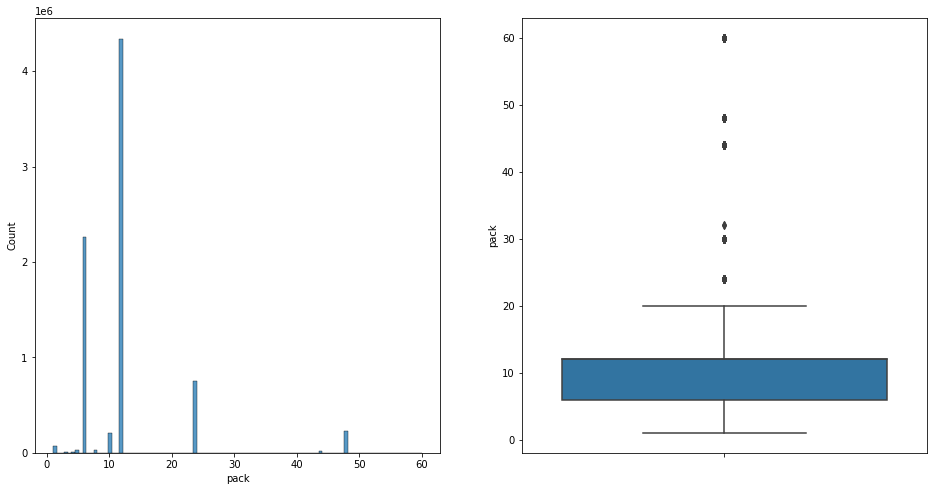

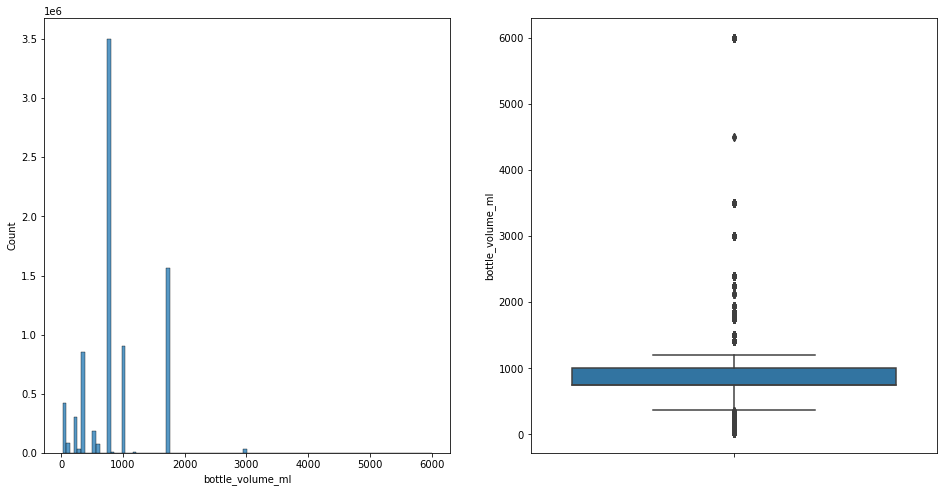

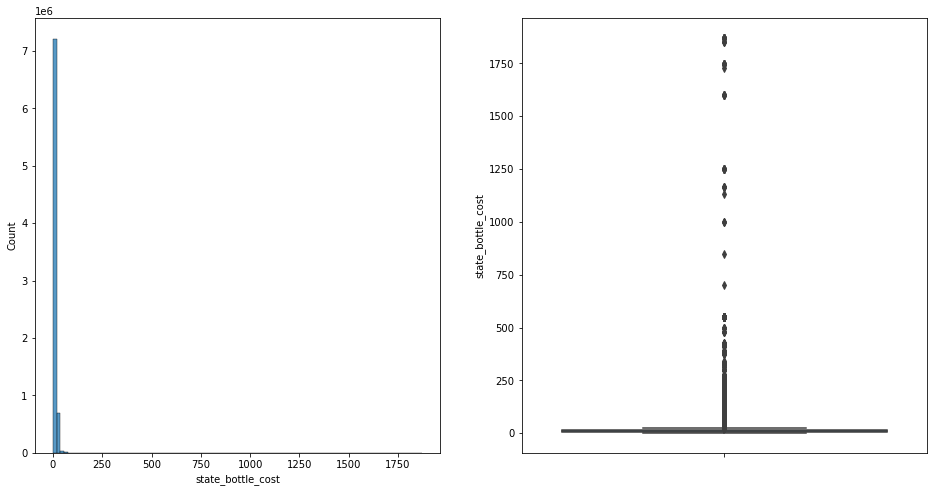

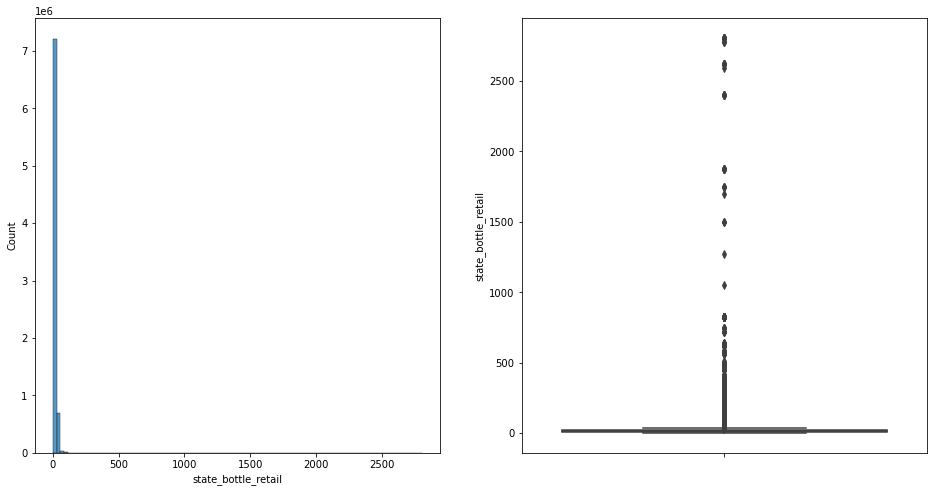

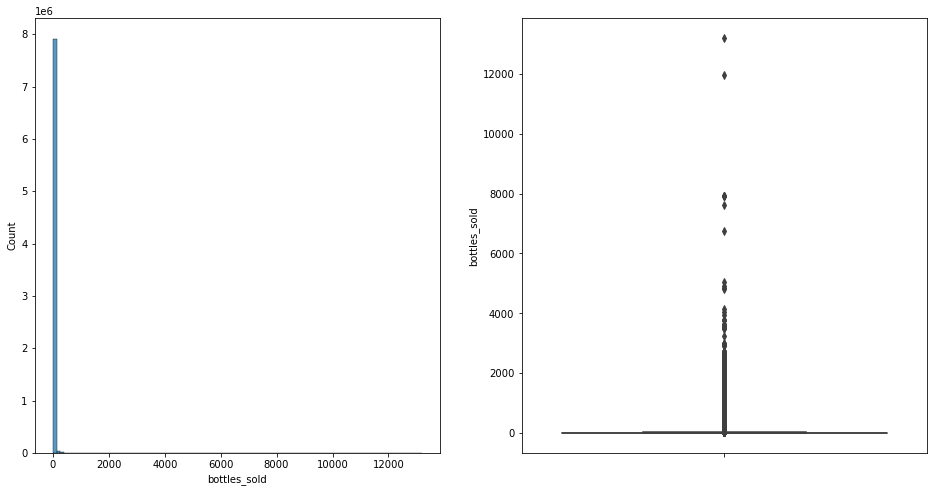

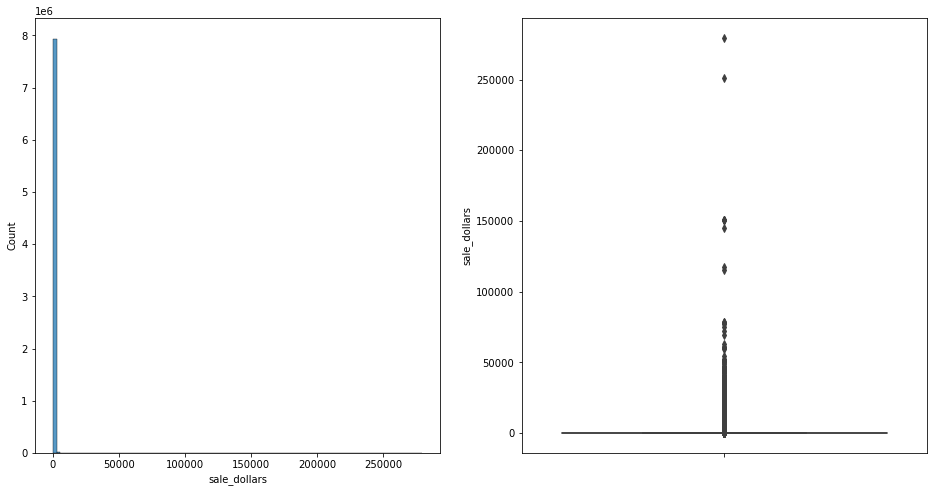

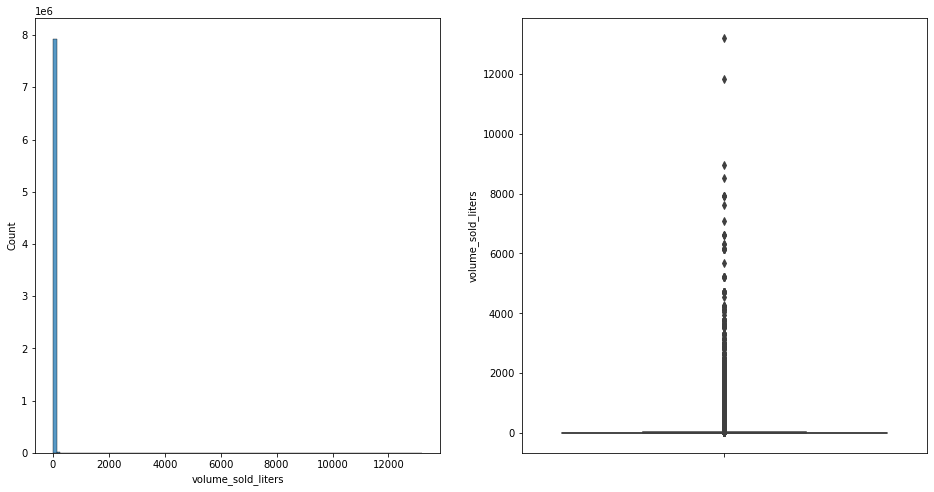

In [33]:
draw_hist_boxplot(liquor_df, num_feature)

Numerical features are heavily skewed with a lot of outliers. This means 2 things I have to do. 
1. Assess whether the outliers genuinely reflects the business transactions (thus retaining the outliers) or a data entry errors (hence either eliminating or correcting outliers). 
2. At a later stage during data preprocessing and ML model training, perform feature scaling and extra careful when choosing an ML model for prediction. Certain ML models (e.g. AdaBoost) do not perform well when having too many outliers. 

In [34]:
# Define a function to identify outliers for numerical features
def isolate_outlier(df, feature):
    Q1 = feature.quantile(0.25)
    Q3 = feature.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    print("lower_whisker: ", lower_whisker, "upper_whisker: ", upper_whisker)
    outliers = df[(feature < lower_whisker) | (feature > upper_whisker)]
    return outliers

#### pack

In [35]:
# Identify records with outliers
isolate_outlier(liquor_df, liquor_df['pack'])

lower_whisker:  -3.0 upper_whisker:  21.0


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item
3,INV-09554500039,2018-01-02,4844,Iowa City Fast Break,"2580, Naples Ave",Iowa City,52240,POINT (-91.571064 41.632792),52,JOHNSON,1031100,American Vodkas,260,DIAGEO AMERICAS,37993,Smirnoff 80prf,48,200,2.54,3.81,48,182.88,9.60,2.54,2018,1,1,37993-Smirnoff 80prf
8,INV-09553800019,2018-01-02,5242,Kum & Go #502 / Iowa City,2303 Muscatine Ave,Iowa City,52240,POINT (-91.50163 41.649545),52,JOHNSON,1031100,American Vodkas,260,DIAGEO AMERICAS,37994,Smirnoff 80prf,24,375,4.75,7.13,12,85.56,4.50,1.19,2018,1,1,37994-Smirnoff 80prf
10,INV-09560200010,2018-01-02,5023,Hawkeye Convenience Stores / 16th Av,250 16th Ave SW,Cedar Rapids,52404,POINT (-91.667665 41.961645),57,LINN,1031100,American Vodkas,434,LUXCO INC,36304,Hawkeye Vodka,24,375,1.86,2.79,24,66.96,9.00,2.38,2018,1,1,36304-Hawkeye Vodka
16,INV-09563100006,2018-01-02,4647,B and B EAST / Waterloo,1615 Bishop Ave,Waterloo,50707,POINT (-92.293057 42.49807),7,BLACK HAWK,1031100,American Vodkas,297,Laird & Company,35913,Five O'clock Vodka,48,200,1.13,1.70,48,81.60,9.60,2.54,2018,1,1,35913-Five O'clock Vodka
29,INV-09570100005,2018-01-02,5376,Casey's General Store # 2687/ Hawarden,1001 Ave E,Hawarden,51023,POINT (-96.48809400000002 42.997039),84,SIOUX,1031100,American Vodkas,297,Laird & Company,35914,Five O'clock Vodka,24,375,1.93,2.90,12,34.80,4.50,1.19,2018,1,1,35914-Five O'clock Vodka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966681,INV-35474900129,2021-03-31,2555,Hy-Vee Food Store / Keokuk,3111 Main,Keokuk,52632,POINT (-91.403752 40.41538),56,LEE,1011400,Tennessee Whiskies,085,Brown Forman Corp.,26823,Jack Daniels Old #7 Black Label,48,200,4.23,6.35,4,25.40,0.80,0.21,2021,3,2,26823-Jack Daniels Old #7 Black Label
7966682,INV-35460700012,2021-03-31,4866,Tobacco Hut #18 / Council Bluffs,429 Veterans Memorial,Council Bluffs,51501,POINT (-95.851844 41.219624),78,POTTAWATTA,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19063,Jim Beam,48,200,3.50,5.25,12,63.00,2.40,0.63,2021,3,2,19063-Jim Beam
7966684,INV-35450600095,2021-03-31,2500,Hy-Vee Food Store #1 / Ames,3800 W Lincoln Way,Ames,50010,None,85,STORY,1071100,Cocktails / RTD,065,Jim Beam Brands,63277,On the Rocks Cocktails Cruzan Mai Tai,24,200,3.26,4.89,24,117.36,4.80,1.26,2021,3,2,63277-On the Rocks Cocktails Cruzan Mai Tai
7966685,INV-35467100009,2021-03-31,5835,Casey's General Store #55 / Marcus,4801 Hwy 143,Marcus,51035,POINT (-95.799712 42.810144),18,CHEROKEE,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19064,Jim Beam,24,375,5.50,8.25,24,198.00,9.00,2.37,2021,3,2,19064-Jim Beam


Background research shows that it is normal for pack value to be up to 48-60. For example, Black Velvet Blended Canadian Whisky can be sold per case of 48 while other pre-made cocktails can be packaged into 60-can case. Therefore, it makes sense to retain the outliers. 

#### bottle_volume_ml

In [36]:
# Identify records with outliers
isolate_outlier(liquor_df, liquor_df['bottle_volume_ml'])

lower_whisker:  375.0 upper_whisker:  1375.0


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item
2,INV-09561800137,2018-01-02,2564,Hy-Vee Food Store #4 / Waterloo,4000 University,Waterloo,50701,POINT (-92.403843 42.505197),7,BLACK HAWK,1031100,American Vodkas,259,Heaven Hill Brands,35418,Burnett's Vodka 80 Prf,6,1750,9.48,14.22,6,85.32,10.50,2.77,2018,1,1,35418-Burnett's Vodka 80 Prf
3,INV-09554500039,2018-01-02,4844,Iowa City Fast Break,"2580, Naples Ave",Iowa City,52240,POINT (-91.571064 41.632792),52,JOHNSON,1031100,American Vodkas,260,DIAGEO AMERICAS,37993,Smirnoff 80prf,48,200,2.54,3.81,48,182.88,9.60,2.54,2018,1,1,37993-Smirnoff 80prf
11,INV-09556500037,2018-01-02,2465,Sid's Beverage Shop,2727 Dodge St,Dubuque,52003,POINT (-90.705328 42.491862),31,DUBUQUE,1031100,American Vodkas,300,McCormick Distilling Co.,40118,Dueces Wild Vodka,6,1750,6.67,10.01,6,60.06,10.50,2.77,2018,1,1,40118-Dueces Wild Vodka
12,INV-09571100017,2018-01-02,3742,Wal-Mart 1625 / Lemars,1111 Holton Dr,Lemars,51031,POINT (-96.185499 42.780675),75,PLYMOUTH,1031100,American Vodkas,301,FIFTH GENERATION INC,38178,Titos Handmade Vodka,6,1750,19.00,28.50,6,166.62,10.50,2.77,2018,1,1,38178-Titos Handmade Vodka
13,INV-09557000013,2018-01-02,5042,Super Stop III / Dubuque,1101 Rhomberg Ave,Dubuque,52001,POINT (-90.660269 42.519502),31,DUBUQUE,1031100,American Vodkas,300,McCormick Distilling Co.,36908,Mccormick Vodka Pet,6,1750,7.47,11.21,12,134.52,21.00,5.55,2018,1,1,36908-Mccormick Vodka Pet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966692,INV-35458300184,2021-03-31,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1081400,American Schnapps,055,SAZERAC COMPANY INC,84172,99 Bananas Mini,10,50,5.16,7.74,2,15.48,0.10,0.02,2021,3,2,84172-99 Bananas Mini
7966695,INV-35442000076,2021-03-31,2661,Hy-Vee Food Store / Sheldon,1989 Park St,Sheldon,51201,POINT (-95.831721 43.186038),71,OBRIEN,1011400,Tennessee Whiskies,085,Brown Forman Corp.,86668,Jack Daniels Tennessee Honey Mini,12,50,9.06,13.59,1,13.59,0.05,0.01,2021,3,2,86668-Jack Daniels Tennessee Honey Mini
7966706,INV-35451800028,2021-03-31,2673,Hy-Vee # 6/ Des Moines,420 Court Ave,Des Moines,50309,POINT (-93.62245400000002 41.584842),77,POLK,1022200,100% Agave Tequila,395,PROXIMO,87508,1800 Silver Mini,6,50,22.10,33.15,2,66.30,0.10,0.02,2021,3,2,87508-1800 Silver Mini
7966711,INV-35480200027,2021-03-31,3645,Wal-Mart 1764 / Windsor Heights,1001 73rd St,Windsor Heights,50311,POINT (-93.716991 41.594787),77,POLK,1032200,Imported Flavored Vodka,065,Jim Beam Brands,35628,Pinnacle Whipped,6,1750,10.00,15.00,6,90.00,10.50,2.77,2021,3,2,35628-Pinnacle Whipped


Certain large format whiskies and vodkas can be sold in the 6000ml format as gift box. Therefore, it makes sense to retain the outliers. 

Addditionally, since different bottle volume might indicate varied demands, it may make sense to experiment with binning bottle volume to identify potential correlation with sales. 

#### state_bottle_cost

In [37]:
# Identify records with outliers
isolate_outlier(liquor_df, liquor_df['state_bottle_cost'])

lower_whisker:  -5.6499999999999995 upper_whisker:  24.189999999999998


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item
43,INV-09561600017,2018-01-02,2572,Hy-Vee Food Store / Cedar Falls,6301 University,Cedar Falls,50613,POINT (-92.435236 42.512789),7,BLACK HAWK,1012200,Scotch Whiskies,240,William Grant & Sons Inc,5159,Glenfiddich 14YR,6,750,26.67,40.01,3,120.03,2.25,0.59,2018,1,1,5159-Glenfiddich 14YR
87,INV-09556500125,2018-01-02,2465,Sid's Beverage Shop,2727 Dodge St,Dubuque,52003,POINT (-90.705328 42.491862),31,DUBUQUE,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64858,Fireball Cinnamon Whiskey Mini Dispenser,1,3000,30.00,45.00,4,180.00,12.00,3.17,2018,1,1,64858-Fireball Cinnamon Whiskey Mini Dispenser
94,INV-09558300167,2018-01-02,2666,Hy-Vee Food Store #2 / State Ankeny,2510 SW State St,Ankeny,50023,POINT (-93.621824 41.705188),77,POLK,1022200,100% Agave Tequila,410,Patron Spirits Company,89626,Patron Reposado Tequila,12,750,28.50,42.75,1,42.00,0.75,0.20,2018,1,1,89626-Patron Reposado Tequila
119,INV-09556800036,2018-01-02,4167,"Iowa Street Market, Inc.",1256 Iowa St,Dubuque,52001,POINT (-90.668138 42.504959),31,DUBUQUE,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,1,47.24,0.75,0.20,2018,1,1,5486-Macallan 12 Yr Single Malt Scotch
126,INV-09556000105,2018-01-02,2524,Hy-Vee Food Store / Dubuque,3500 Dodge St,Dubuque,52001,None,31,DUBUQUE,1081200,Cream Liqueurs,305,Mhw LTD,73054,Rumchata,6,1750,24.34,36.51,6,219.06,10.50,2.77,2018,1,1,73054-Rumchata
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966680,INV-35474700023,2021-03-31,2191,Keokuk Spirits,1013 Main,Keokuk,52632,POINT (-91.387797 40.400038),56,LEE,1022200,100% Agave Tequila,035,BACARDI USA INC,88296,Patron Silver,12,750,27.50,41.25,12,495.00,9.00,2.37,2021,3,2,88296-Patron Silver
7966686,INV-35468800028,2021-03-31,5353,New Star / Pella,977 198th Pl.,Pella,50219,POINT (-92.953534 41.38105500000001),63,MARION,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84145,99 Grapes PET Mini,1,50,51.60,77.40,1,77.40,0.05,0.01,2021,3,2,84145-99 Grapes PET Mini
7966693,INV-35445000072,2021-03-31,2650,Hy-Vee Wine and Spirits / Harlan,1808 23rd St,Harlan,51537,POINT (-95.339881 41.650658),83,SHELBY,1022200,100% Agave Tequila,085,Brown Forman Corp.,89339,Herradura Reposado,6,750,27.00,40.50,3,121.50,2.25,0.59,2021,3,2,89339-Herradura Reposado
7966700,INV-35478400017,2021-03-31,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1022200,100% Agave Tequila,035,BACARDI USA INC,88296,Patron Silver,12,750,27.50,41.25,24,990.00,18.00,4.75,2021,3,2,88296-Patron Silver


In [38]:
liquor_df[liquor_df['state_bottle_cost'] == 0.33]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item
6670995,INV-30680300131,2020-10-01,2545,Hy-Vee Drugstore / Iowa City,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,3,101.25,0.60,0.15,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...
6672227,INV-30685900055,2020-10-01,2248,Ingersoll Liquor and Beverage,3500 Ingersoll Ave,Des Moines,50312,POINT (-93.664182 41.586319),77,POLK,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,6,202.50,1.20,0.31,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...
6673723,INV-30688900035,2020-10-01,5684,Five Corners Liquor & Wine,809 E 18th St,Cedar Falls,50613,POINT (-92.436845 42.5214),7,BLACK HAWK,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,1,33.75,0.20,0.05,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...
6673797,INV-30697700001,2020-10-01,9001,Cedar Ridge Vineyards,1441 Marak Rd NW,Swisher,52338,POINT (-91.67737 41.8321),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,30,1012.50,6.00,1.58,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...
6704035,INV-30784000001,2020-10-06,2535,Hy-Vee Food Store #1 / WDM,1700 Valley West Dr,West Des Moines,50265,None,77,POLK,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,6,202.50,1.20,0.31,2020,10,1,100672-Cedar Ridge American Whiskey Sampler Co...
6708661,INV-30835000009,2020-10-07,4268,Fareway Stores #531 / Algona,1905 Highway 18 E,Algona,50511,POINT (-94.214064 43.082782),55,KOSSUTH,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,1,33.75,0.20,0.05,2020,10,2,100672-Cedar Ridge American Whiskey Sampler Co...
6712480,INV-30842300006,2020-10-07,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,6,202.50,1.20,0.31,2020,10,2,100672-Cedar Ridge American Whiskey Sampler Co...
6714205,INV-30839300016,2020-10-07,2285,John's Grocery,401 East Market St,Iowa City,52240,POINT (-91.529854 41.663541),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,12,405.00,2.40,0.63,2020,10,2,100672-Cedar Ridge American Whiskey Sampler Co...
6715973,INV-30860500001,2020-10-08,9001,Cedar Ridge Vineyards,1441 Marak Rd NW,Swisher,52338,POINT (-91.67737 41.8321),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,12,405.00,2.40,0.63,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...
6717712,INV-30856800003,2020-10-08,5734,Fareway Stores #193 / Tiffin,500 Croell Avenue,Tiffin,52340,POINT (-91.657407 41.708639),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,1,33.75,0.20,0.05,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...


For this specific item "Cedar Ridge American Whiskey Sampler Collection" that has the lowest state_bottle_cost, the sale_dollars is much higher than bottles_sold * state_bottle_retail. This could potentially indicate data quality issues. Hence, I will check whether such mismatching occurs for any other product or not. 

In [39]:
# Review transactions whereby sales_dollars exceeds 75% of stated retail price per bottle
liquor_df['sale_calculation'] = liquor_df['bottles_sold'] * liquor_df['state_bottle_retail']
liquor_df['sale_calculation_test'] = np.where((liquor_df['sale_dollars'] - liquor_df['sale_calculation'])/liquor_df['sale_calculation'] <= 0.75
                                              , "Matched", "Not Matched")
liquor_df[liquor_df['sale_calculation_test'] == "Not Matched"]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
20380,INV-09597400006,2018-01-04,9906,Johnson Brothers Wirtz,2515 Dean Avenue,Des Moines,50317,POINT (-93.570027 41.591304),77,POLK,1042100,Imported Dry Gins,389,REMY COINTREAU USA INC,28905,The Botanist Islay Dry Gin,6,750,19.99,29.99,2,179.94,1.50,0.39,2018,1,3,28905-The Botanist Islay Dry Gin,59.98,Not Matched
20948,INV-09597400005,2018-01-04,9906,Johnson Brothers Wirtz,2515 Dean Avenue,Des Moines,50317,POINT (-93.570027 41.591304),77,POLK,1031100,American Vodkas,519,Colorado Gold Distillery,36673,Colorado High Vodka,12,750,11.00,16.50,1,198.00,0.75,0.19,2018,1,3,36673-Colorado High Vodka,16.50,Not Matched
21005,INV-09597400001,2018-01-04,9906,Johnson Brothers Wirtz,2515 Dean Avenue,Des Moines,50317,POINT (-93.570027 41.591304),77,POLK,1081200,Cream Liqueurs,368,Park Street Imports,78592,Adelaides Caramel Mocha Mojo,12,750,10.38,15.57,1,186.84,0.75,0.19,2018,1,3,78592-Adelaides Caramel Mocha Mojo,15.57,Not Matched
21514,INV-09597400010,2018-01-04,9906,Johnson Brothers Wirtz,2515 Dean Avenue,Des Moines,50317,POINT (-93.570027 41.591304),77,POLK,1011200,Straight Bourbon Whiskies,085,Brown Forman Corp.,20366,Old Forester Bourbon,12,750,9.88,14.82,1,177.84,0.75,0.19,2018,1,3,20366-Old Forester Bourbon,14.82,Not Matched
22211,INV-09597400003,2018-01-04,9906,Johnson Brothers Wirtz,2515 Dean Avenue,Des Moines,50317,POINT (-93.570027 41.591304),77,POLK,1011600,Straight Rye Whiskies,085,Brown Forman Corp.,27181,Jack Daniels Tennessee Rye,12,750,17.07,25.61,1,307.32,0.75,0.19,2018,1,3,27181-Jack Daniels Tennessee Rye,25.61,Not Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6825616,INV-31293900001,2020-10-23,9001,Cedar Ridge Vineyards,1441 Marak Rd NW,Swisher,52338,POINT (-91.67737 41.8321),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,18,607.50,3.60,0.95,2020,10,4,100672-Cedar Ridge American Whiskey Sampler Co...,9.00,Not Matched
6868004,INV-31488600001,2020-10-29,9001,Cedar Ridge Vineyards,1441 Marak Rd NW,Swisher,52338,POINT (-91.67737 41.8321),52,JOHNSON,1011200,Straight Bourbon Whiskies,125,CEDAR RIDGE VINEYARDS LL,100672,Cedar Ridge American Whiskey Sampler Collection,6,200,0.33,0.50,18,607.50,3.60,0.95,2020,10,3,100672-Cedar Ridge American Whiskey Sampler Co...,9.00,Not Matched
7210392,INV-32750800055,2020-12-15,6041,Liquor Downtown / Iowa City,315 S Gilbert St,Iowa City,52240,POINT (-91.530181 41.657654),52,JOHNSON,1071100,Cocktails / RTD,368,Park Street Imports,58213,Crafthouse Cocktails Rum Old Fashioned,6,750,11.00,16.50,6,180.00,4.50,1.18,2020,12,1,58213-Crafthouse Cocktails Rum Old Fashioned,99.00,Not Matched
7237026,INV-32829800001,2020-12-18,2635,Hy-Vee #4 / Davenport,4064 E 53rd St,Davenport,52807,POINT (-90.513769 41.574973),82,SCOTT,1071100,Cocktails / RTD,368,Park Street Imports,58213,Crafthouse Cocktails Rum Old Fashioned,6,750,11.00,16.50,6,180.00,4.50,1.18,2020,12,4,58213-Crafthouse Cocktails Rum Old Fashioned,99.00,Not Matched


Different experiments with the data highlight 3 observations. 
1. Although the data definition stated that sale_dollars = state_bottle_retail * bottles_sold, the actual sale_dollars captured could be higher or lower. 
2. The sale_dollars could be much lower, which could indicate significant discount to get rid of slow-moving inventory. This corresponds with standard business practices. 
3. There are certain products that the Iowa Alcoholic Beverages Division has sold to retailers at a price that is much higher than the stated bottle retail price (sometimes at a markup of 75% and above). I am not sure whether it is data quality issue or represents a valid business scenario. In real life, this is where business domain knowledge comes into the picture. Specifically, a workflow can be setup to automatically isolate such abnormal records and notify relevant data owners for data quality review. 

For now, I will assume this is normal business practice and retain both state_bottle_cost and sales_dollars values as they are. 

#### state_bottle_retail

In [40]:
# Identify records with outliers
isolate_outlier(liquor_df, liquor_df['state_bottle_retail'])

lower_whisker:  -8.475 upper_whisker:  36.285


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
43,INV-09561600017,2018-01-02,2572,Hy-Vee Food Store / Cedar Falls,6301 University,Cedar Falls,50613,POINT (-92.435236 42.512789),7,BLACK HAWK,1012200,Scotch Whiskies,240,William Grant & Sons Inc,5159,Glenfiddich 14YR,6,750,26.67,40.01,3,120.03,2.25,0.59,2018,1,1,5159-Glenfiddich 14YR,120.03,Matched
87,INV-09556500125,2018-01-02,2465,Sid's Beverage Shop,2727 Dodge St,Dubuque,52003,POINT (-90.705328 42.491862),31,DUBUQUE,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64858,Fireball Cinnamon Whiskey Mini Dispenser,1,3000,30.00,45.00,4,180.00,12.00,3.17,2018,1,1,64858-Fireball Cinnamon Whiskey Mini Dispenser,180.00,Matched
94,INV-09558300167,2018-01-02,2666,Hy-Vee Food Store #2 / State Ankeny,2510 SW State St,Ankeny,50023,POINT (-93.621824 41.705188),77,POLK,1022200,100% Agave Tequila,410,Patron Spirits Company,89626,Patron Reposado Tequila,12,750,28.50,42.75,1,42.00,0.75,0.20,2018,1,1,89626-Patron Reposado Tequila,42.75,Matched
119,INV-09556800036,2018-01-02,4167,"Iowa Street Market, Inc.",1256 Iowa St,Dubuque,52001,POINT (-90.668138 42.504959),31,DUBUQUE,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,1,47.24,0.75,0.20,2018,1,1,5486-Macallan 12 Yr Single Malt Scotch,52.49,Matched
126,INV-09556000105,2018-01-02,2524,Hy-Vee Food Store / Dubuque,3500 Dodge St,Dubuque,52001,None,31,DUBUQUE,1081200,Cream Liqueurs,305,Mhw LTD,73054,Rumchata,6,1750,24.34,36.51,6,219.06,10.50,2.77,2018,1,1,73054-Rumchata,219.06,Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966680,INV-35474700023,2021-03-31,2191,Keokuk Spirits,1013 Main,Keokuk,52632,POINT (-91.387797 40.400038),56,LEE,1022200,100% Agave Tequila,035,BACARDI USA INC,88296,Patron Silver,12,750,27.50,41.25,12,495.00,9.00,2.37,2021,3,2,88296-Patron Silver,495.00,Matched
7966686,INV-35468800028,2021-03-31,5353,New Star / Pella,977 198th Pl.,Pella,50219,POINT (-92.953534 41.38105500000001),63,MARION,1081300,American Cordials & Liqueurs,055,SAZERAC COMPANY INC,84145,99 Grapes PET Mini,1,50,51.60,77.40,1,77.40,0.05,0.01,2021,3,2,84145-99 Grapes PET Mini,77.40,Matched
7966693,INV-35445000072,2021-03-31,2650,Hy-Vee Wine and Spirits / Harlan,1808 23rd St,Harlan,51537,POINT (-95.339881 41.650658),83,SHELBY,1022200,100% Agave Tequila,085,Brown Forman Corp.,89339,Herradura Reposado,6,750,27.00,40.50,3,121.50,2.25,0.59,2021,3,2,89339-Herradura Reposado,121.50,Matched
7966700,INV-35478400017,2021-03-31,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1022200,100% Agave Tequila,035,BACARDI USA INC,88296,Patron Silver,12,750,27.50,41.25,24,990.00,18.00,4.75,2021,3,2,88296-Patron Silver,990.00,Matched


Validation against actual price of liquor reveals the outlier reflects normal business transactions. Hence the outliers will be retained. 

#### bottles_sold

In [41]:
# Identify records with outliers
isolate_outlier(liquor_df, liquor_df['bottles_sold'])

lower_whisker:  -10.5 upper_whisker:  25.5


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
3,INV-09554500039,2018-01-02,4844,Iowa City Fast Break,"2580, Naples Ave",Iowa City,52240,POINT (-91.571064 41.632792),52,JOHNSON,1031100,American Vodkas,260,DIAGEO AMERICAS,37993,Smirnoff 80prf,48,200,2.54,3.81,48,182.88,9.60,2.54,2018,1,1,37993-Smirnoff 80prf,182.88,Matched
5,INV-09559000017,2018-01-02,2665,Hy-Vee / Waukee,1005 E Hickman Rd,Waukee,50263,POINT (-93.854477 41.615059),25,DALLAS,1062500,Flavored Rum,370,PERNOD RICARD USA,42716,Malibu Coconut Rum,12,750,7.49,11.24,36,404.64,27.00,7.13,2018,1,1,42716-Malibu Coconut Rum,404.64,Matched
16,INV-09563100006,2018-01-02,4647,B and B EAST / Waterloo,1615 Bishop Ave,Waterloo,50707,POINT (-92.293057 42.49807),7,BLACK HAWK,1031100,American Vodkas,297,Laird & Company,35913,Five O'clock Vodka,48,200,1.13,1.70,48,81.60,9.60,2.54,2018,1,1,35913-Five O'clock Vodka,81.60,Matched
21,INV-09549600030,2018-01-02,2527,Hy-Vee Food Store #5 / Des Moines,1107 SE Army Post Rd,Des Moines,50315,POINT (-93.602372 41.526289),77,POLK,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,72,969.84,54.00,14.27,2018,1,1,64865-Fireball Cinnamon Whiskey PET,969.84,Matched
69,INV-09550400050,2018-01-02,2549,Hy-Vee Food Store / Indianola,910 N Jefferson,Indianola,50125,None,91,WARREN,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64867,Fireball Cinnamon Whiskey,12,1000,11.34,17.01,36,612.36,36.00,9.51,2018,1,1,64867-Fireball Cinnamon Whiskey,612.36,Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966589,INV-35449400017,2021-03-31,5144,Sam's Club 6979 / Ankeny,4625 SE Delaware Ave,Ankeny,50021,POINT (-93.581273 41.691),77,POLK,1011400,Tennessee Whiskies,085,Brown Forman Corp.,26827,Jack Daniels Old #7 Black Label,12,1000,18.89,28.34,36,1020.24,36.00,9.51,2021,3,2,26827-Jack Daniels Old #7 Black Label,1020.24,Matched
7966630,INV-35476500077,2021-03-31,3952,Lot-A-Spirits,3780 State St,Bettendorf,52722,POINT (-90.48065 41.529655),82,SCOTT,1032100,Imported Vodkas,035,BACARDI USA INC,34422,Grey Goose,6,1000,22.75,34.13,48,1638.24,48.00,12.68,2021,3,2,34422-Grey Goose,1638.24,Matched
7966647,INV-35459200009,2021-03-31,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1012100,Canadian Whiskies,260,DIAGEO AMERICAS,11297,Crown Royal,12,1000,19.39,29.09,72,2040.48,72.00,19.02,2021,3,2,11297-Crown Royal,2094.48,Matched
7966675,INV-35457200003,2021-03-31,5655,One Stop Shop #3 / Algona,220 S Phillips St,Algona,50511,POINT (-94.226877 43.06732),55,KOSSUTH,1012100,Canadian Whiskies,259,Heaven Hill Brands,10548,Black Velvet Toasted Caramel,6,1750,10.45,15.68,30,470.40,52.50,13.86,2021,3,2,10548-Black Velvet Toasted Caramel,470.40,Matched


In [42]:
liquor_df[liquor_df['bottles_sold'] ==13200.00]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
6720185,INV-30852400189,2020-10-08,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,13200,250932.00,13200.00,3487.07,2020,10,3,38177-Titos Handmade Vodka,250932.00,Matched


In [43]:
liquor_df[liquor_df['bottles_sold'] == 0]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
970264,INV-12453700001,2018-06-05,9911,Southern Glazers Wine & Spirits of Iowa,3100 SE Grimes Blvd. Ste 100,Grimes,50111,POINT (-93.774496 41.657621),77,POLK,1012300,Single Malt Scotch,370,PERNOD RICARD USA,5153,Glenlivet Founders Reserve,12,750,19.98,29.97,0,359.64,0.06,0.01,2018,6,1,5153-Glenlivet Founders Reserve,0.00,Not Matched


The above record highlights a data quality issue with bottles_sold = 0. For such scenarios, I will calculate the bottles_sold = sale_dollars / state_bottle_cost.

In [44]:
liquor_df['bottles_sold'] = np.where(liquor_df['bottles_sold'] == 0, 
                                     (liquor_df['sale_dollars'] / liquor_df['state_bottle_cost']).astype('int64'), 
                                     liquor_df['bottles_sold'])

In [45]:
liquor_df[liquor_df['invoice_and_item_number']=="INV-12453700001"]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
970264,INV-12453700001,2018-06-05,9911,Southern Glazers Wine & Spirits of Iowa,3100 SE Grimes Blvd. Ste 100,Grimes,50111,POINT (-93.774496 41.657621),77,POLK,1012300,Single Malt Scotch,370,PERNOD RICARD USA,5153,Glenlivet Founders Reserve,12,750,19.98,29.97,18,359.64,0.06,0.01,2018,6,1,5153-Glenlivet Founders Reserve,0.00,Not Matched


#### sale_dollars

In [46]:
# Identify records with outliers
isolate_outlier(liquor_df, liquor_df['sale_dollars'])

lower_whisker:  -134.82000000000002 upper_whisker:  318.78000000000003


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
5,INV-09559000017,2018-01-02,2665,Hy-Vee / Waukee,1005 E Hickman Rd,Waukee,50263,POINT (-93.854477 41.615059),25,DALLAS,1062500,Flavored Rum,370,PERNOD RICARD USA,42716,Malibu Coconut Rum,12,750,7.49,11.24,36,404.64,27.00,7.13,2018,1,1,42716-Malibu Coconut Rum,404.64,Matched
21,INV-09549600030,2018-01-02,2527,Hy-Vee Food Store #5 / Des Moines,1107 SE Army Post Rd,Des Moines,50315,POINT (-93.602372 41.526289),77,POLK,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,72,969.84,54.00,14.27,2018,1,1,64865-Fireball Cinnamon Whiskey PET,969.84,Matched
69,INV-09550400050,2018-01-02,2549,Hy-Vee Food Store / Indianola,910 N Jefferson,Indianola,50125,None,91,WARREN,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64867,Fireball Cinnamon Whiskey,12,1000,11.34,17.01,36,612.36,36.00,9.51,2018,1,1,64867-Fireball Cinnamon Whiskey,612.36,Matched
72,INV-09550400137,2018-01-02,2549,Hy-Vee Food Store / Indianola,910 N Jefferson,Indianola,50125,None,91,WARREN,1012100,Canadian Whiskies,115,CONSTELLATION BRANDS INC,10550,Black Velvet Toasted Caramel,12,750,6.75,10.13,120,1215.60,90.00,23.78,2018,1,1,10550-Black Velvet Toasted Caramel,1215.60,Matched
95,INV-09558000012,2018-01-02,5236,"Giggle Juice Liquor Station, LLC",600 W Main St,Anamosa,52205,POINT (-91.29083400000002 42.108203),53,JONES,1011400,Tennessee Whiskies,085,Brown Forman Corp.,26827,Jack Daniels Old #7 Black Lbl,12,1000,18.89,28.34,12,340.08,12.00,3.17,2018,1,1,26827-Jack Daniels Old #7 Black Lbl,340.08,Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966687,INV-35481000068,2021-03-31,2648,Hy-Vee #4 / WDM,555 S 51st St,West Des Moines,50265,POINT (-93.773557 41.561197),77,POLK,1011600,Straight Rye Whiskies,255,Infinium Spirits,27102,Templeton Rye 4YR,6,750,18.09,27.14,120,3256.80,90.00,23.77,2021,3,2,27102-Templeton Rye 4YR,3256.80,Matched
7966689,INV-35477700021,2021-03-31,5916,Another Round / DeWitt,622 S 6th Ave,DeWitt,52742,POINT (-90.539095 41.808535),23,CLINTON,1011600,Straight Rye Whiskies,255,Infinium Spirits,27175,Templeton Rye 4YR,6,1000,21.00,31.50,12,378.00,12.00,3.17,2021,3,2,27175-Templeton Rye 4YR,378.00,Matched
7966694,INV-35478700001,2021-03-31,2590,Hy-Vee Food Store #5 / Cedar Rapids,3235 Oakland Road NE,Cedar Rapids,52402,POINT (-91.658105 42.010971),57,LINN,1011400,Tennessee Whiskies,085,Brown Forman Corp.,86693,Jack Daniels Tennessee Fire,12,1000,18.89,28.34,12,340.08,12.00,3.17,2021,3,2,86693-Jack Daniels Tennessee Fire,340.08,Matched
7966700,INV-35478400017,2021-03-31,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1022200,100% Agave Tequila,035,BACARDI USA INC,88296,Patron Silver,12,750,27.50,41.25,24,990.00,18.00,4.75,2021,3,2,88296-Patron Silver,990.00,Matched


In [47]:
large_sales = liquor_df[liquor_df['sale_dollars'] >= 100000]
large_sales

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
1735153,INV-14774700005,2018-10-02,2663,Hy-Vee Food Store / Urbandale,8701 Douglas,Urbandale,50322,POINT (-93.739105 41.629364),77,POLK,1012100,Canadian Whiskies,260,DIAGEO AMERICAS,11296,Crown Royal,12,750,15.59,23.39,11952,279557.28,8964.00,2368.03,2018,10,1,11296-Crown Royal,279557.28,Matched
6574844,INV-30337300001,2020-09-18,3354,Sam's Club 8238 / Davenport,3845 Elmore Ave.,Davenport,52807,POINT (-90.527081 41.559731),82,SCOTT,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,7920,150559.20,7920.00,2092.24,2020,9,4,38177-Titos Handmade Vodka,150559.20,Matched
6575199,INV-30354800002,2020-09-18,3944,Sam's Club 4973 / Dubuque,4400 Asbury Rd,Dubuque,52002,POINT (-90.737821 42.515289),31,DUBUQUE,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,7920,150559.20,7920.00,2092.24,2020,9,4,38177-Titos Handmade Vodka,150559.20,Matched
6606519,INV-30439100003,2020-09-22,3447,Sam's Club 6432 / Sioux City,4201 S. York St.,Sioux City,51106,POINT (-96.37082 42.43407),97,WOODBURY,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,7920,150559.20,7920.00,2092.24,2020,9,1,38177-Titos Handmade Vodka,150559.20,Matched
6609907,INV-30483400004,2020-09-23,3477,Sam's Club 6472 / Council Bluffs,3221 Manawa Centre Dr,Council Bluffs,51501,POINT (-95.847163 41.225208),78,POTTAWATTA,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,7920,150559.20,7920.00,2092.24,2020,9,2,38177-Titos Handmade Vodka,150559.20,Matched
6611643,INV-30492200002,2020-09-23,3524,Sam's Club 6568 / Ames,305 Airport Rd,Ames,50010,POINT (-93.613648 42.001123),85,STORY,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,7632,145084.32,7632.00,2016.16,2020,9,2,38177-Titos Handmade Vodka,145084.32,Matched
6622542,INV-30498200003,2020-09-24,2663,Hy-Vee Food Store / Urbandale,8701 Douglas,Urbandale,50322,POINT (-93.739105 41.629364),77,POLK,1701100,Temporary & Specialty Packages,260,DIAGEO AMERICAS,100639,Crown Royal w/NFL Jersey Bag,12,750,15.59,23.39,5037,117815.43,3777.75,997.97,2020,9,3,100639-Crown Royal w/NFL Jersey Bag,117815.43,Matched
6671189,INV-30676500001,2020-10-01,2663,Hy-Vee Food Store / Urbandale,8701 Douglas,Urbandale,50322,POINT (-93.739105 41.629364),77,POLK,1012100,Canadian Whiskies,260,DIAGEO AMERICAS,11296,Crown Royal,12,750,15.59,23.39,4920,115078.80,3690.00,974.79,2020,10,3,11296-Crown Royal,115078.80,Matched
6720185,INV-30852400189,2020-10-08,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1031100,American Vodkas,301,FIFTH GENERATION INC,38177,Titos Handmade Vodka,12,1000,12.67,19.01,13200,250932.00,13200.00,3487.07,2020,10,3,38177-Titos Handmade Vodka,250932.00,Matched


9 special orders exceeding 100,000 dollars represents one-off transactions. Since they do not reflect the general liquor demand across the year, I would remove these transactional data.

In [48]:
# Remove transactional data exceeding 100,000 dollars to mitigate one-off outliers
liquor_df = liquor_df[liquor_df['sale_dollars'] <= 100000]

In [49]:
liquor_df[liquor_df['sale_dollars'] == 0]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day_of_week,item,sale_calculation,sale_calculation_test
10859,INV-09573000001,2018-01-03,4392,KUM & GO #156 / CLIVE,15600 Hickman Rd,Clive,50325,POINT (-93.834209 41.614732),77,POLK,1062400,Spiced Rum,260,DIAGEO AMERICAS,43334,Captain Morgan Spiced Rum,24,375,5.00,7.50,2,0.00,0.75,0.19,2018,1,2,43334-Captain Morgan Spiced Rum,15.00,Matched
12483,INV-09582400001,2018-01-03,3909,D And S Grocery,104 SE A St,Melcher-Dallas,50163,POINT (-93.24163400000002 41.222471),63,MARION,1081400,American Schnapps,065,Jim Beam Brands,82844,Dekuyper Luscious Peachtree,24,375,3.06,4.59,2,0.00,0.75,0.19,2018,1,2,82844-Dekuyper Luscious Peachtree,9.18,Matched
12542,INV-09582300001,2018-01-03,4634,Kwik Shop #565 / Cedar Rapids,"4201, Center Point Rd NE",Cedar Rapids,52402,POINT (-91.665659 42.021931),57,LINN,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64858,Fireball Cinnamon Whiskey Mini Dispenser,1,3000,30.00,45.00,2,0.00,6.00,1.58,2018,1,2,64858-Fireball Cinnamon Whiskey Mini Dispenser,90.00,Matched
13156,INV-09584900001,2018-01-03,4655,Casey's General Store #2237 / Prairie City,1002 W 2nd St,Prairie City,50228,POINT (-93.247591 41.596714),50,JASPER,1081100,Coffee Liqueurs,370,PERNOD RICARD USA,67526,Kahlua Coffee Liqueur,12,750,11.99,17.99,1,0.00,0.75,0.19,2018,1,2,67526-Kahlua Coffee Liqueur,17.99,Matched
14497,INV-09573100001,2018-01-03,2106,Hillstreet News and Tobacco,2217 College,Cedar Falls,50613,POINT (-92.455796 42.517182),7,BLACK HAWK,1011200,Straight Bourbon Whiskies,065,Jim Beam Brands,19068,Jim Beam,6,1750,20.99,31.49,3,0.00,5.25,1.38,2018,1,2,19068-Jim Beam,94.47,Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314799,INV-13495500001,2018-07-27,4458,QUIK TRIP #568 / JOHNSTON,5169 Merle Hay Rd,Johnston,50131,POINT (-93.69753300000002 41.654161),77,POLK,1031100,American Vodkas,260,DIAGEO AMERICAS,37996,Smirnoff 80prf,12,750,8.25,12.38,1,0.00,0.75,0.19,2018,7,4,37996-Smirnoff 80prf,12.38,Matched
1316259,INV-13503500001,2018-07-27,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,1062500,Flavored Rum,305,Mhw LTD,42244,Blue Chair Bay Coconut Spiced,12,750,9.42,14.13,1,0.00,0.75,0.19,2018,7,4,42244-Blue Chair Bay Coconut Spiced,14.13,Matched
1316644,INV-13495600001,2018-07-27,4868,Kum & Go #59 / Waukee,400 Prairie Bluff Dr,Waukee,50263,POINT (-93.880018 41.565606),25,DALLAS,1011400,Tennessee Whiskies,085,Brown Forman Corp.,26821,Jack Daniels Old #7 Black Lbl Mini,12,500,9.06,13.59,1,0.00,0.50,0.13,2018,7,4,26821-Jack Daniels Old #7 Black Lbl Mini,13.59,Matched
1318132,INV-13495400001,2018-07-27,5228,Anthon Mini Mart,"101, W Main St",Anthon,51004,POINT (-95.868594 42.388265),97,WOODBURY,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28866,Tanqueray Gin,12,750,13.00,19.50,4,0.00,3.00,0.79,2018,7,4,28866-Tanqueray Gin,78.00,Matched


The above records with zero sale_dollars could indicate data quality issue, fraudulent transactions or normal business practice. In real life, this is where business domain knowledge comes into the picture. However, since the volume of these records is relatively low, I will not proceed with any further research to determine the root cause. 

Additionally, since sale_dollars is zero, I would treat these records as missing labels. As such, I will remove these records. 

In [50]:
# Remove records with zero sale_dollars (i.e. missing labels)
liquor_df =  liquor_df[liquor_df['sale_dollars']>0]

In [51]:
liquor_df.shape

(7966218, 30)

## Review existing data to identify suitable approach to correct inconsistent item_number and item_description

In [52]:
# Create an item catalog
item_list = liquor_df.drop_duplicates(subset=['item_number', 'item_description', 'pack', 'bottle_volume_ml'])
unique_product = item_list[['item_number', 'item_description', 'pack', 'bottle_volume_ml']]
unique_product

,item_number,item_description,pack,bottle_volume_ml
0,18350,Four Roses Single Barrel,6,750
1,43352,Captain Morgan Pineapple,12,750
2,35418,Burnett's Vodka 80 Prf,6,1750
3,37993,Smirnoff 80prf,48,200
4,72913,Captain Morgan Loconut,6,750
...,...,...,...,...
7958057,57279,Chi-Chi's Pink Lemonade Margarita,6,1750
7958523,73809,RumChata Mocha Cold Brew,6,1750
7963621,28894,Bombay Bramble,1,50
7963647,946608,Modern Matriarch Salted Caramel Flavored Rum,12,750


In [53]:
# Identify duplicated item_number for analysis
unique_product['duplicated'] = unique_product.duplicated(subset=['item_number', 'bottle_volume_ml'], keep = False)
unique_product['item_description_length'] = unique_product['item_description'].str.len()
duplicated_item_number = unique_product[unique_product['duplicated'] == True].sort_values(by=['item_number'])

In [54]:
duplicated_item_number.tail(50)

,item_number,item_description,pack,bottle_volume_ml,duplicated,item_description_length
7648639,988915,SOOH Codigo 1530 Tequila Anejo,3,750,True,30
5511464,988915,Codigo 1530 Tequila Anejo,3,750,True,25
1743211,989288,Kirkland Signature Blended Scotch 12YR,6,1750,True,38
1354426,989288,Kirkland Signature 12YR Blended Scotch Whisky,6,1750,True,45
5880694,989411,Del Maguey Chichicapa,6,750,True,21
1464090,989411,Del Maguey Chichicapa Tequila,6,750,True,29
502282,989622,1921 Anejo,6,750,True,10
2506320,989622,1921 Tequila Anejo,6,750,True,18
3429090,990225,Uncle Vals Restorative Gin,6,750,True,26
310282,990225,Uncle Val's Restorative Gin,6,750,True,27


In [55]:
duplicated_item_number['non_decodable_removed'] = duplicated_item_number['item_description'].str.replace('�','')
duplicated_item_number.tail(50)

,item_number,item_description,pack,bottle_volume_ml,duplicated,item_description_length,non_decodable_removed
7648639,988915,SOOH Codigo 1530 Tequila Anejo,3,750,True,30,SOOH Codigo 1530 Tequila Anejo
5511464,988915,Codigo 1530 Tequila Anejo,3,750,True,25,Codigo 1530 Tequila Anejo
1743211,989288,Kirkland Signature Blended Scotch 12YR,6,1750,True,38,Kirkland Signature Blended Scotch 12YR
1354426,989288,Kirkland Signature 12YR Blended Scotch Whisky,6,1750,True,45,Kirkland Signature 12YR Blended Scotch Whisky
5880694,989411,Del Maguey Chichicapa,6,750,True,21,Del Maguey Chichicapa
1464090,989411,Del Maguey Chichicapa Tequila,6,750,True,29,Del Maguey Chichicapa Tequila
502282,989622,1921 Anejo,6,750,True,10,1921 Anejo
2506320,989622,1921 Tequila Anejo,6,750,True,18,1921 Tequila Anejo
3429090,990225,Uncle Vals Restorative Gin,6,750,True,26,Uncle Vals Restorative Gin
310282,990225,Uncle Val's Restorative Gin,6,750,True,27,Uncle Val's Restorative Gin


Based on the observed patterns for inconsistent item_description for the same item_number, I will standardise the item_list according to the following rules. 
- For item_description containing undecodable character (e.g. Three Olives 1.75L w/Three Olives Ros� 375ml), remove the undecodable character to shorten the name
- Choose longer description over shorter description to avoid ambiguity. For example, choose Jose Cuervo Authentic Pink Lemonade Margarita over Jose Cuervo Authentic Pink Lemonade

#### Clean the inconsistent item_number and item_description

In [56]:
item_list.shape

(7546, 30)

In [57]:
# Isolate relevant columns
item_list = item_list[['item_number', 'item_description']]

In [58]:
# Remove undecodable character in the item_description
item_list['item_description'] = item_list['item_description'].str.replace('�','')
item_list['item_description_length'] = item_list['item_description'].str.len()
item_list.head(50)

,item_number,item_description,item_description_length
0,18350,Four Roses Single Barrel,24
1,43352,Captain Morgan Pineapple,24
2,35418,Burnett's Vodka 80 Prf,22
3,37993,Smirnoff 80prf,14
4,72913,Captain Morgan Loconut,22
5,42716,Malibu Coconut Rum,18
6,43026,Admiral Nelson Spiced Rum,25
7,15626,Jameson,7
8,37994,Smirnoff 80prf,14
9,65199,Tequila Rose Liqueur,20


In [59]:
# Sort item_list by item_number and item_description_length to facilitate deduplication
item_list = item_list.sort_values(by = ['item_number', 'item_description_length'], ascending = False)
item_list

,item_number,item_description,item_description_length
4865260,999449,TF Gran Classico Bitter,23
4849743,999440,TF Crme Cacao Van,17
2519499,999292,Gran Centenario Anejo,21
4345982,999280,Stone Castle Verak XO Brandy,28
6245086,999199,Benjamin Prichard''s Double Chocolate Bourbon ...,53
...,...,...,...
281355,100024,Fernet Branca Liqueur w/2 Bodega Glasses,40
13774,100018,Barenjager Honey w/2 Rocks Glasses,34
26571,100017,Hornitos Reposado w/ Hornitos Plata 200ml,41
5787329,100015,Fireball Cinnamon Whiskey Bag in Box,36


In [60]:
# Deduplicate by item_number
item_list = item_list.drop_duplicates(subset=['item_number'])
item_list.head(50)

,item_number,item_description,item_description_length
4865260,999449,TF Gran Classico Bitter,23
4849743,999440,TF Crme Cacao Van,17
2519499,999292,Gran Centenario Anejo,21
4345982,999280,Stone Castle Verak XO Brandy,28
6245086,999199,Benjamin Prichard''s Double Chocolate Bourbon ...,53
5166514,998888,Dubouchett Peach Schnapps,25
4537000,998606,The Big Smoke 46%,17
732819,998546,Hornitos Plata,14
6518077,997880,American Barrels Kentucky Bourbon Whiskey,41
5011921,997878,Beer Barrel Bourbon,19


In [61]:
# Drop item_description_length and save the master data
item_list = item_list.drop(columns = 'item_description_length')
pd.to_pickle(item_list, item_data)
item_list.tail(50)

,item_number,item_description
4262831,100301,Makers Mark 46 w/2 Glasses
46075,100300,Seagrams Extra Smooth Vodka 1.75L w/Juicy Wate...
156258,100298,St Brendans Irish Cream w/3-50mls
4006817,100294,Deep Eddy w/Thermos
70290,100293,Heaven Hill Whiskey In A Tube
469994,100282,Glen Moray Classic Chardonnay Cask Finish w/2 ...
6283036,100280,The Bitter Truth Cocktail Bar Pack
3369,100258,Patron Silver Version 3.0
63525,100246,Kerrygold Irish Cream Liqueur w/2 Glasses
8847,100245,Bombay Sapphire Gift Tin


**FUTURE IMPROVEMENTS**

Similar liquor products are captured under different item_number values (despite having the same packaging volume). This might limit the ability to consolidate and monitor demand across the same product line. Therefore, further research and exploration with fuzzy matching could be done to group the same products for demand forecasting. 

In [62]:
# Check the number of unique values (i.e. cardinality) for each categorical feature
cat_feature = ['date', 'city', 'county', 'category_name', 'vendor_name', 'item_description', 'item_number']
liquor_df[cat_feature].nunique()

date                 847
city                 443
county               100
category_name         49
vendor_name          271
item_description    5938
item_number         6134
dtype: int64

## Summarise transactional data & update item_description

In [63]:
# Calculate the total sale_dollars, bottles_sold, volume_sold_liters grouped by date, item_number, vendor_number, category, city
summarised_sales = liquor_df.groupby(['date', 'item_number', 'vendor_name', 'category_name', 'city', 'county', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'pack'])['sale_dollars', 'bottles_sold', 'volume_sold_liters'].sum()
summarised_sales = summarised_sales.reset_index()

In [64]:
summarised_sales = summarised_sales.merge(item_list, how = 'inner', on = 'item_number')
summarised_sales

,date,item_number,vendor_name,category_name,city,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,pack,sale_dollars,bottles_sold,volume_sold_liters,item_description
0,2018-01-02,10006,DIAGEO AMERICAS,Scotch Whiskies,Dubuque,DUBUQUE,750,5.13,7.70,12,15.40,2,1.50,Scoresby Rare Scotch
1,2018-01-03,10006,DIAGEO AMERICAS,Scotch Whiskies,DeWitt,CLINTON,750,5.13,7.70,12,92.40,12,9.00,Scoresby Rare Scotch
2,2018-01-03,10006,DIAGEO AMERICAS,Scotch Whiskies,Emmetsburg,PALO ALTO,750,5.13,7.70,12,92.40,12,9.00,Scoresby Rare Scotch
3,2018-01-03,10006,DIAGEO AMERICAS,Scotch Whiskies,Knoxville,MARION,750,5.13,7.70,12,30.80,4,3.00,Scoresby Rare Scotch
4,2018-01-03,10006,DIAGEO AMERICAS,Scotch Whiskies,Nevada,STORY,750,5.13,7.70,12,15.40,2,1.50,Scoresby Rare Scotch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073614,2021-03-31,38530,SAZERAC COMPANY INC,American Vodkas,Cedar Falls,BLACK HAWK,50,4.30,6.45,12,6.45,1,0.05,Wheatley Vodka Mini
6073615,2021-03-31,57279,SAZERAC COMPANY INC,Cocktails / RTD,Cedar Rapids,LINN,1750,6.50,9.75,6,58.50,6,10.50,Chi-Chi's Pink Lemonade Margarita
6073616,2021-03-31,917527,Brown Forman Corp.,Straight Bourbon Whiskies,Allerton,WAYNE,750,17.15,25.73,6,154.38,6,4.50,Coopers' Craft Reserve Kentucky Straight Bourb...
6073617,2021-03-31,946606,Modern Matriarch,Gold Rum,Council Bluffs,POTTAWATTA,750,14.00,21.00,12,504.00,24,18.00,Modern Matriarch Amber Rum


In [66]:
# Saved summarised data as pickle file, ready for further EDA
summarised_sales.to_parquet(summarised_data)